In [1]:
# Import packages

import pandas as pd
pd.set_option('display.max_columns', None)
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
import requests
import io

auth = ('FDS_DEMO_EUR_464603_SERVICES', '6hc85SGcgWCrkbJo')

In [2]:
## Define the names of factors that you are interested and enter their corresponding screening formulas

qfl_data = pd.read_excel('QFL.xlsx', header = 1)

qfl_data = qfl_data.drop(['Unnamed: 0'], axis = 1)

qfl_data.head()

,Factor Group,Field ID,Field Name,FactSet Screening Formula,Data Source,Unnamed: 6,Currency,Shares,CACCESS,Search Keywords,Data Type,String Length
0,Asset Data,DAYS_SINCE_RPT,Days Since Report,QFL_DAYS_SINCE_RPT(0),FactSet Estimates,"'Days Since Report': 'QFL_DAYS_SINCE_RPT(0)',",None,0,00QFL,"asset,data,estimates",INTEGER,NaN
1,Asset Data,DAYS_TO_RPT,Days to Report,QFL_DAYS_TO_RPT(0),FactSet Estimates,"'Days to Report': 'QFL_DAYS_TO_RPT(0)',",None,0,00QFL,"asset,data,estimates",INTEGER,NaN
2,Asset Data,ADR_FLAG,ADR Flag,QFL_ADR_FLAG(0),FactSet Reference Data,"'ADR Flag': 'QFL_ADR_FLAG(0)',",None,0,00QFL,"asset,reference,data",INTEGER,NaN
3,Asset Data,BANKRUPTCY,Bankruptcy Flag,QFL_BANKRUPTCY(0),FactSet Reference Data,"'Bankruptcy Flag': 'QFL_BANKRUPTCY(0)',",None,0,00QFL,"asset,reference,data",INTEGER,NaN
4,Asset Data,PRIMARY_LIST,Primary Listing,QFL_PRIMARY_LIST(0),FactSet Reference Data,"'Primary Listing': 'QFL_PRIMARY_LIST(0)',",None,0,00QFL,"asset,reference,data",INTEGER,NaN


In [3]:
# create QFL factor categories dictionary: Key = Field Name, Values = FactSet Screening Formula

qfl_categories = qfl_data['Factor Group'].unique()
qfl_categories = list(np.delete(qfl_categories, [0,1,2]))

for i in qfl_categories:
    globals()['qfl_{0}'.format(i).lower()] = dict(qfl_data[qfl_data['Factor Group'] == i][['FactSet Screening Formula', 'FactSet Screening Formula']].values)

qfl_categories

['Size',
 'Value',
 'Growth',
 'Profitability',
 'Efficiency',
 'Solvency',
 'Management',
 'Quality',
 'Analyst Sentiment',
 'Crowding',
 'Insider Activity',
 'Corporate Governance',
 'Momentum',
 'Volatility',
 'Market Sensitivity',
 'Technical',
 'Liquidity']

In [4]:
qfl_factors = globals()['qfl_{0}'.format('Corporate Governance').lower()] # change QFL Category here!

formulas = list(qfl_factors.values())
columns = list(qfl_factors.keys())

In [5]:
# Define Universe & QFL parameters

endpoint = "https://datadirect.factset.com/services/FastFetch?"
factlet = "ExtractBenchmarkDetail"

ids = "890100"
date = "11/30/2020"
fwd_date = "12/31/2020"

# Forward Returns, Size Class, Security Market Value (USD)

params = ['P_TOTAL_RETURN(' + str(date) + ',' + str(fwd_date) + ')',
          'QFL_SIZE_CLASS(' + str(date) + ')',
          'QFL_MKT_VAL_SEC(' + str(date) + ')']

items = 'PROPER_NAME, FG_GICS_SECTOR, PROPER(FG_COUNTRY)'

items_call = items + ',' + ','.join([str(elem) for elem in params]) + ',' + ','.join([str(qfl_elem) for qfl_elem in list(qfl_factors.values())])

# cutoff = "10"
output_format = "pipe"
showTitle = "N"
showHeader = "N"
showDataType = "N"

response = requests.post(endpoint, auth=auth, data = {'factlet':factlet, 
                                                      'ids':ids, 
                                                      'items': items_call,
                                                      'dates':date, 
                                                      # 'cutoff':cutoff,
                                                      'format':output_format,
                                                      'showTitle':showTitle,
                                                      'showHeader':showHeader,
                                                      'showDataType':showDataType})

df = pd.read_csv(io.StringIO(response.text), sep = '|')

In [6]:
col_universe = ['BENCHMARK_ID', 'DATE', 'SECURITY_ID', 'Weight', 'proper_name',
       'fg_gics_sector', 'proper', 'p_total_return', 'qfl_size_class', 'qfl_mkt_val_sec']
items_call_pipe = '|'.join([str(qfl_elem) for qfl_elem in list(qfl_factors.values())])
columns_name = col_universe + items_call_pipe.split('|')
df.columns = pd.Index(columns_name)

In [7]:
qfl_df = df

In [8]:
qfl_df.head()

,BENCHMARK_ID,DATE,SECURITY_ID,Weight,proper_name,fg_gics_sector,proper,p_total_return,qfl_size_class,qfl_mkt_val_sec,QFL_MGMT_NUM(0),"QFL_MGMT_AGE(0,AVG)","QFL_MGMT_AGE(0,MAX)","QFL_MGMT_AGE(0,MED)","QFL_MGMT_AGE(0,MIN)","QFL_MGMT_TENURE(0,AVG)","QFL_MGMT_TENURE(0,MAX)","QFL_MGMT_TENURE(0,MED)","QFL_MGMT_TENURE(0,MIN)",QFL_MGMT_COMP_AVG(0),QFL_MGMT_CEO_CHAIR(0),QFL_MGMT_FOUNDER_LED(0),QFL_MGMT_FEMALE_CEO(0),QFL_MGMT_CONNECTIONS(0),"QFL_BRD_NUM_TOT(0,TOTAL)","QFL_BRD_AGE(0,AVG)","QFL_BRD_AGE(0,MAX)","QFL_BRD_AGE(0,MED)","QFL_BRD_AGE(0,MIN)","QFL_BRD_TENURE(0,AVG)","QFL_BRD_TENURE(0,MAX)","QFL_BRD_TENURE(0,MED)","QFL_BRD_TENURE(0,MIN)","QFL_BRD_NUM_IND(0,IND)",QFL_BRD_NUM_OTH_BRD(0),QFL_BRD_NUM_OTH_CORP_BRD(0),"QFL_BRD_NUM_FEM(0,FEMALE)",QFL_BRD_FEMALE_CHAIR(0),QFL_BRD_PEVC(0),QFL_BRD_ACTIVIST(0),QFL_BRD_FMR_CEO(0),QFL_BRD_CONNECTIONS(0),"QFL_DAYS_SINCE_MGMT_CHG(0,CEO)","QFL_DAYS_SINCE_MGMT_CHG(0,CFO)","QFL_DAYS_SINCE_BRD_CHG(0,CHAIR)","QFL_DAYS_SINCE_BRD_CHG(0,DIR)","QFL_DAYS_SINCE_BRD_CHG(0,IND_DIR)","QFL_EXEC_COMP(0,SALARY,AVG)","QFL_EXEC_COMP(0,SALARY,MAX)","QFL_EXEC_COMP(0,SALARY,MED)","QFL_EXEC_COMP(0,SALARY,MIN)","QFL_EXEC_COMP(0,SALARY,SUM)","QFL_EXEC_COMP(0,BONUS,AVG)","QFL_EXEC_COMP(0,BONUS,MAX)","QFL_EXEC_COMP(0,BONUS,MED)","QFL_EXEC_COMP(0,BONUS,MIN)","QFL_EXEC_COMP(0,BONUS,SUM)","QFL_EXEC_COMP(0,STOCK,AVG)","QFL_EXEC_COMP(0,STOCK,MAX)","QFL_EXEC_COMP(0,STOCK,MED)","QFL_EXEC_COMP(0,STOCK,MIN)","QFL_EXEC_COMP(0,STOCK,SUM)","QFL_EXEC_COMP(0,OPTION,AVG)","QFL_EXEC_COMP(0,OPTION,MAX)","QFL_EXEC_COMP(0,OPTION,MED)","QFL_EXEC_COMP(0,OPTION,MIN)","QFL_EXEC_COMP(0,OPTION,SUM)","QFL_EXEC_COMP(0,TOTAL,AVG)","QFL_EXEC_COMP(0,TOTAL,MAX)","QFL_EXEC_COMP(0,TOTAL,MED)","QFL_EXEC_COMP(0,TOTAL,MIN)","QFL_EXEC_COMP(0,TOTAL,SUM)",QFL_EXEC_CONNECTIONS(0),QFL_FOUNDER_CONNECTIONS(0)
0,890100,30-Nov-2020,03783310,4.204100,Apple Inc.,Information Technology,United States,11.457372,Mega Cap,2024064.4,31.0,53.00,59.0,55.0,41.0,14.73,34.50,12.41,1.36,21272920.0,0.0,0.0,0.0,1672.0,7.0,66.00,71.0,70.0,58.0,13.74,22.75,12.91,5.25,6.0,7.0,7.0,2.0,0.0,1.0,0.0,0.0,1876.0,NaN,1948.0,NaN,NaN,NaN,1251310.1,3000000.0,1000000.0,630361.0,7507861.0,NaN,NaN,NaN,NaN,NaN,20600638.0,21633416.0,21633416.0,16469527.0,103003190.0,NaN,NaN,NaN,NaN,NaN,21440474.0,25231800.0,23743080.0,11555466.0,21440474.0,166.0,0.0
1,890100,30-Nov-2020,59491810,3.141281,Microsoft Corporation,Information Technology,United States,3.900588,Mega Cap,1618475.4,59.0,53.10,61.0,53.0,42.0,10.72,36.91,7.08,0.05,23641260.0,0.0,0.0,0.0,1854.0,12.0,58.92,71.0,59.0,51.0,6.72,28.91,5.00,1.00,11.0,12.0,12.0,5.0,0.0,1.0,0.0,0.0,3689.0,NaN,NaN,NaN,NaN,NaN,1165400.0,2500000.0,860000.0,715000.0,5827000.0,NaN,NaN,NaN,NaN,NaN,15074426.0,30718608.0,12402137.0,6983520.0,75372130.0,NaN,NaN,NaN,NaN,NaN,20828104.0,44321788.0,16667713.0,9575482.0,20828104.0,501.0,0.0
2,890100,30-Nov-2020,02313510,2.735749,"Amazon.com, Inc.",Consumer Discretionary,United States,2.805829,Mega Cap,1589567.8,27.0,53.50,56.0,54.0,50.0,16.11,26.42,17.42,2.16,12040263.0,1.0,1.0,0.0,113.0,11.0,63.91,75.0,63.0,56.0,9.67,26.42,6.42,0.22,10.0,7.0,7.0,5.0,0.0,1.0,0.0,0.0,2724.0,NaN,2009.0,NaN,82.0,82.0,153368.0,175000.0,175000.0,81840.0,766840.0,NaN,NaN,NaN,NaN,NaN,57573240.0,57573240.0,57573240.0,57573240.0,57573240.0,NaN,NaN,NaN,NaN,NaN,12040263.0,57796740.0,348809.0,163200.0,12040263.0,9.0,9.0
3,890100,30-Nov-2020,30303M10,1.356526,"Facebook, Inc. Class A",Communication Services,United States,-1.375598,Mega Cap,665827.3,42.0,47.12,55.0,48.0,34.0,7.29,16.82,6.75,0.44,22568776.0,1.0,1.0,0.0,1991.0,9.0,51.78,72.0,50.0,35.0,6.91,16.82,1.50,0.68,7.0,9.0,9.0,4.0,0.0,1.0,0.0,0.0,1672.0,NaN,1795.0,NaN,NaN,NaN,559846.6,875385.0,785385.0,1.0,2799233.0,1324960.3,2291288.0,1099312.5,809928.0,5299841.0,18836496.0,19678924.0,19678924.0,16309218.0,75345980.0,NaN,NaN,NaN,NaN,NaN,22568776.0,27144148.0,21812976.0,19136744.0,22568776.0,420.0,2.0
4,890100,30-Nov-2020,02079K10,1.085045,Alphabet Inc. Class C,Communication Services,United States,-0.503194,

In [9]:
qfl_df.tail()

,BENCHMARK_ID,DATE,SECURITY_ID,Weight,proper_name,fg_gics_sector,proper,p_total_return,qfl_size_class,qfl_mkt_val_sec,QFL_MGMT_NUM(0),"QFL_MGMT_AGE(0,AVG)","QFL_MGMT_AGE(0,MAX)","QFL_MGMT_AGE(0,MED)","QFL_MGMT_AGE(0,MIN)","QFL_MGMT_TENURE(0,AVG)","QFL_MGMT_TENURE(0,MAX)","QFL_MGMT_TENURE(0,MED)","QFL_MGMT_TENURE(0,MIN)",QFL_MGMT_COMP_AVG(0),QFL_MGMT_CEO_CHAIR(0),QFL_MGMT_FOUNDER_LED(0),QFL_MGMT_FEMALE_CEO(0),QFL_MGMT_CONNECTIONS(0),"QFL_BRD_NUM_TOT(0,TOTAL)","QFL_BRD_AGE(0,AVG)","QFL_BRD_AGE(0,MAX)","QFL_BRD_AGE(0,MED)","QFL_BRD_AGE(0,MIN)","QFL_BRD_TENURE(0,AVG)","QFL_BRD_TENURE(0,MAX)","QFL_BRD_TENURE(0,MED)","QFL_BRD_TENURE(0,MIN)","QFL_BRD_NUM_IND(0,IND)",QFL_BRD_NUM_OTH_BRD(0),QFL_BRD_NUM_OTH_CORP_BRD(0),"QFL_BRD_NUM_FEM(0,FEMALE)",QFL_BRD_FEMALE_CHAIR(0),QFL_BRD_PEVC(0),QFL_BRD_ACTIVIST(0),QFL_BRD_FMR_CEO(0),QFL_BRD_CONNECTIONS(0),"QFL_DAYS_SINCE_MGMT_CHG(0,CEO)","QFL_DAYS_SINCE_MGMT_CHG(0,CFO)","QFL_DAYS_SINCE_BRD_CHG(0,CHAIR)","QFL_DAYS_SINCE_BRD_CHG(0,DIR)","QFL_DAYS_SINCE_BRD_CHG(0,IND_DIR)","QFL_EXEC_COMP(0,SALARY,AVG)","QFL_EXEC_COMP(0,SALARY,MAX)","QFL_EXEC_COMP(0,SALARY,MED)","QFL_EXEC_COMP(0,SALARY,MIN)","QFL_EXEC_COMP(0,SALARY,SUM)","QFL_EXEC_COMP(0,BONUS,AVG)","QFL_EXEC_COMP(0,BONUS,MAX)","QFL_EXEC_COMP(0,BONUS,MED)","QFL_EXEC_COMP(0,BONUS,MIN)","QFL_EXEC_COMP(0,BONUS,SUM)","QFL_EXEC_COMP(0,STOCK,AVG)","QFL_EXEC_COMP(0,STOCK,MAX)","QFL_EXEC_COMP(0,STOCK,MED)","QFL_EXEC_COMP(0,STOCK,MIN)","QFL_EXEC_COMP(0,STOCK,SUM)","QFL_EXEC_COMP(0,OPTION,AVG)","QFL_EXEC_COMP(0,OPTION,MAX)","QFL_EXEC_COMP(0,OPTION,MED)","QFL_EXEC_COMP(0,OPTION,MIN)","QFL_EXEC_COMP(0,OPTION,SUM)","QFL_EXEC_COMP(0,TOTAL,AVG)","QFL_EXEC_COMP(0,TOTAL,MAX)","QFL_EXEC_COMP(0,TOTAL,MED)","QFL_EXEC_COMP(0,TOTAL,MIN)","QFL_EXEC_COMP(0,TOTAL,SUM)",QFL_EXEC_CONNECTIONS(0),QFL_FOUNDER_CONNECTIONS(0)
1595,890100,30-Nov-2020,BZ22BK,0.002738,SmartCentres Real Estate Investment Trust,Real Estate,Canada,-3.552645,Mid Cap,2688.3582,18.0,61.75,68.0,61.5,56.0,7.65,19.67,5.50,1.33,NaN,0.0,1.0,0.0,7.0,8.0,63.00,75.0,63.0,55.0,14.62,31.91,16.22,1.50,5.0,4.0,4.0,0.0,0.0,0.0,0.0,0.0,1337.0,883.0,NaN,1020.0,549.0,549.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0,91.0
1596,890100,30-Nov-2020,B2NT8S,0.002637,"Seven Bank, Ltd.",Financials,Japan,-4.803491,Mid Cap,2619.2988,10.0,62.67,69.0,63.0,53.0,12.23,19.00,13.29,3.50,NaN,0.0,0.0,0.0,10.0,10.0,63.20,70.0,64.5,53.0,9.39,19.00,7.54,2.45,4.0,5.0,5.0,1.0,0.0,0.0,0.0,0.0,133.0,NaN,NaN,891.0,NaN,892.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0
1597,890100,30-Nov-2020,BKSLS5,0.002617,First Capital Real Estate Investment Trust,Real Estate,Canada,-12.513375,Mid Cap,2634.8494,6.0,48.00,51.0,48.0,45.0,2.39,3.67,2.39,1.12,NaN,0.0,0.0,0.0,252.0,9.0,59.00,72.0,57.5,45.0,NaN,NaN,NaN,NaN,0.0,9.0,9.0,2.0,0.0,0.0,0.0,0.0,1713.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,216.0,0.0
1598,890100,30-Nov-2020,659844,0.002463,Mitsubishi Motors Corporation,Consumer Discretionary,Japan,15.425528,Mid Cap,2808.4746,11.0,60.17,65.0,61.5,51.0,17.53,38.67,4.50,3.67,NaN,0.0,0.0,0.0,14.0,15.0,66.53,72.0,67.0,58.0,6.51,36.67,4.00,1.44,6.0,9.0,9.0,4.0,0.0,0.0,0.0,1.0,402.0,525.0,971.0,727.0,525.0,525.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0
1599,890100,30-Nov-2020,656950,0.002419,Maruichi Steel Tube Ltd.,Materials,Japan,4.007292,Small Cap,2063.3816,9.0,65.60,74.0,65.0,57.0,33.63,43.75,39.75,7.58,NaN,1.0,0.0,0.0,16.0,7.0,66.71,74.0,69.0,51.0,25.73,43.75,36.75,2.50,3.0,5.0,5.0,0.0,0.0,0.0,0.0,0.0,26.0,NaN,NaN,NaN,179.0,910.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9.0,0.0


In [10]:
# Summary Stats

qfl_df.describe()

,BENCHMARK_ID,Weight,p_total_return,qfl_mkt_val_sec,QFL_MGMT_NUM(0),"QFL_MGMT_AGE(0,AVG)","QFL_MGMT_AGE(0,MAX)","QFL_MGMT_AGE(0,MED)","QFL_MGMT_AGE(0,MIN)","QFL_MGMT_TENURE(0,AVG)","QFL_MGMT_TENURE(0,MAX)","QFL_MGMT_TENURE(0,MED)","QFL_MGMT_TENURE(0,MIN)",QFL_MGMT_COMP_AVG(0),QFL_MGMT_CEO_CHAIR(0),QFL_MGMT_FOUNDER_LED(0),QFL_MGMT_FEMALE_CEO(0),QFL_MGMT_CONNECTIONS(0),"QFL_BRD_NUM_TOT(0,TOTAL)","QFL_BRD_AGE(0,AVG)","QFL_BRD_AGE(0,MAX)","QFL_BRD_AGE(0,MED)","QFL_BRD_AGE(0,MIN)","QFL_BRD_TENURE(0,AVG)","QFL_BRD_TENURE(0,MAX)","QFL_BRD_TENURE(0,MED)","QFL_BRD_TENURE(0,MIN)","QFL_BRD_NUM_IND(0,IND)",QFL_BRD_NUM_OTH_BRD(0),QFL_BRD_NUM_OTH_CORP_BRD(0),"QFL_BRD_NUM_FEM(0,FEMALE)",QFL_BRD_FEMALE_CHAIR(0),QFL_BRD_PEVC(0),QFL_BRD_ACTIVIST(0),QFL_BRD_FMR_CEO(0),QFL_BRD_CONNECTIONS(0),"QFL_DAYS_SINCE_MGMT_CHG(0,CEO)","QFL_DAYS_SINCE_MGMT_CHG(0,CFO)","QFL_DAYS_SINCE_BRD_CHG(0,CHAIR)","QFL_DAYS_SINCE_BRD_CHG(0,DIR)","QFL_DAYS_SINCE_BRD_CHG(0,IND_DIR)","QFL_EXEC_COMP(0,SALARY,AVG)","QFL_EXEC_COMP(0,SALARY,MAX)","QFL_EXEC_COMP(0,SALARY,MED)","QFL_EXEC_COMP(0,SALARY,MIN)","QFL_EXEC_COMP(0,SALARY,SUM)","QFL_EXEC_COMP(0,BONUS,AVG)","QFL_EXEC_COMP(0,BONUS,MAX)","QFL_EXEC_COMP(0,BONUS,MED)","QFL_EXEC_COMP(0,BONUS,MIN)","QFL_EXEC_COMP(0,BONUS,SUM)","QFL_EXEC_COMP(0,STOCK,AVG)","QFL_EXEC_COMP(0,STOCK,MAX)","QFL_EXEC_COMP(0,STOCK,MED)","QFL_EXEC_COMP(0,STOCK,MIN)","QFL_EXEC_COMP(0,STOCK,SUM)","QFL_EXEC_COMP(0,OPTION,AVG)","QFL_EXEC_COMP(0,OPTION,MAX)","QFL_EXEC_COMP(0,OPTION,MED)","QFL_EXEC_COMP(0,OPTION,MIN)","QFL_EXEC_COMP(0,OPTION,SUM)","QFL_EXEC_COMP(0,TOTAL,AVG)","QFL_EXEC_COMP(0,TOTAL,MAX)","QFL_EXEC_COMP(0,TOTAL,MED)","QFL_EXEC_COMP(0,TOTAL,MIN)","QFL_EXEC_COMP(0,TOTAL,SUM)",QFL_EXEC_CONNECTIONS(0),QFL_FOUNDER_CONNECTIONS(0)
count,1600.0,1600.000000,1597.000000,1.598000e+03,1596.000000,1578.000000,1578.000000,1578.000000,1578.000000,1595.000000,1595.000000,1595.000000,1595.000000,6.240000e+02,1598.000000,1598.000000,1598.000000,1598.000000,1596.000000,1586.000000,1586.000000,1586.000000,1586.000000,1587.000000,1587.000000,1587.00000,1587.000000,1596.000000,1596.000000,1596.000000,1596.000000,1598.000000,1598.000000,1598.000000,1598.000000,1598.000000,914.000000,989.000000,861.000000,1140.000000,906.000000,6.230000e+02,6.230000e+02,6.230000e+02,6.230000e+02,6.230000e+02,2.420000e+02,2.420000e+02,2.420000e+02,2.420000e+02,2.420000e+02,5.990000e+02,5.990000e+02,5.990000e+02,5.990000e+02,5.990000e+02,3.290000e+02,3.290000e+02,3.290000e+02,3.290000e+02,3.290000e+02,6.250000e+02,6.250000e+02,6.250000e+02,6.250000e+02,6.250000e+02,1598.000000,1598.000000
mean,890100.0,0.062500,3.118575,3.489420e+04,14.358396,55.419677,62.731939,55.405894,48.118504,13.422696,26.007461,12.606564,4.048276,7.445444e+06,0.228411,0.121402,0.049437,597.319775,10.998120,61.573670,72.850567,61.585435,49.836696,10.601997,25.104568,9.49017,1.477227,6.394110,8.939223,8.607143,2.877820,0.060075,0.420526,0.021902,0.188360,1332.683354,1080.864333,889.706775,947.803717,365.793860,610.684327,7.336920e+05,1.226378e+06,6.592634e+05,4.444295e+05,3.888854e+06,1.086206e+06,1.567116e+06,1.004874e+06,7.782559e+05,3.167708e+06,4.757703e+06,9.553695e+06,3.772159e+06,2.694786e+06,2.001418e+07,1.825249e+06,3.912903e+06,1.379941e+06,9.326196e+05,7.750096e+06,7.103618e+06,1.641803e+07,5.207088e+06,3.147279e+06,7.103618e+06,273.692115,22.705882
std,0.0,0.177252,7.256757,9.150908e+04,15.709530,4.661751,6.225095,4.849431,6.399847,9.342479,12.288549,10.776993,7.313992,8.939483e+06,0.419940,0.326696,0.216846,1137.918465,3.109596,4.120823,5.922613,4.438694,6.468985,7.052905,14.388295,8.81649,1.773569,3.258661,3.281668,3.221079,1.768618,0.237700,0.493798,0.146411,0.391122,1500.618215,689.209080,562.093528,557.521085,339.904059,507.293919,4.294109e+05,1.088780e+06,2.974534e+05,2.292623e+05,2.491985e+06,1.535945e+06,2.590163e+06,1.455446e+06,1.095529e+06,6.306683e+06,1.629661e+07,1.759522e+07,1.629879e+07,1.618042e+07,2.293986e+07,2.539597e+06,4.619006e+06,2.399705e+06,2.064100e+06,8.460686e+06,5.506826e+0

In [11]:
# Check NAs

qfl_df.isna().sum()

BENCHMARK_ID                    0
DATE                            0
SECURITY_ID                     0
Weight                          0
proper_name                     0
                             ... 
QFL_EXEC_COMP(0,TOTAL,MED)    975
QFL_EXEC_COMP(0,TOTAL,MIN)    975
QFL_EXEC_COMP(0,TOTAL,SUM)    975
QFL_EXEC_CONNECTIONS(0)         2
QFL_FOUNDER_CONNECTIONS(0)      2
Length: 74, dtype: int64

In [12]:
# Filter for float/numeric parameters only

filter_idx = [idx for idx, col in enumerate(qfl_df.columns) if idx > 9 and qfl_df[col].values.dtype == 'float64']

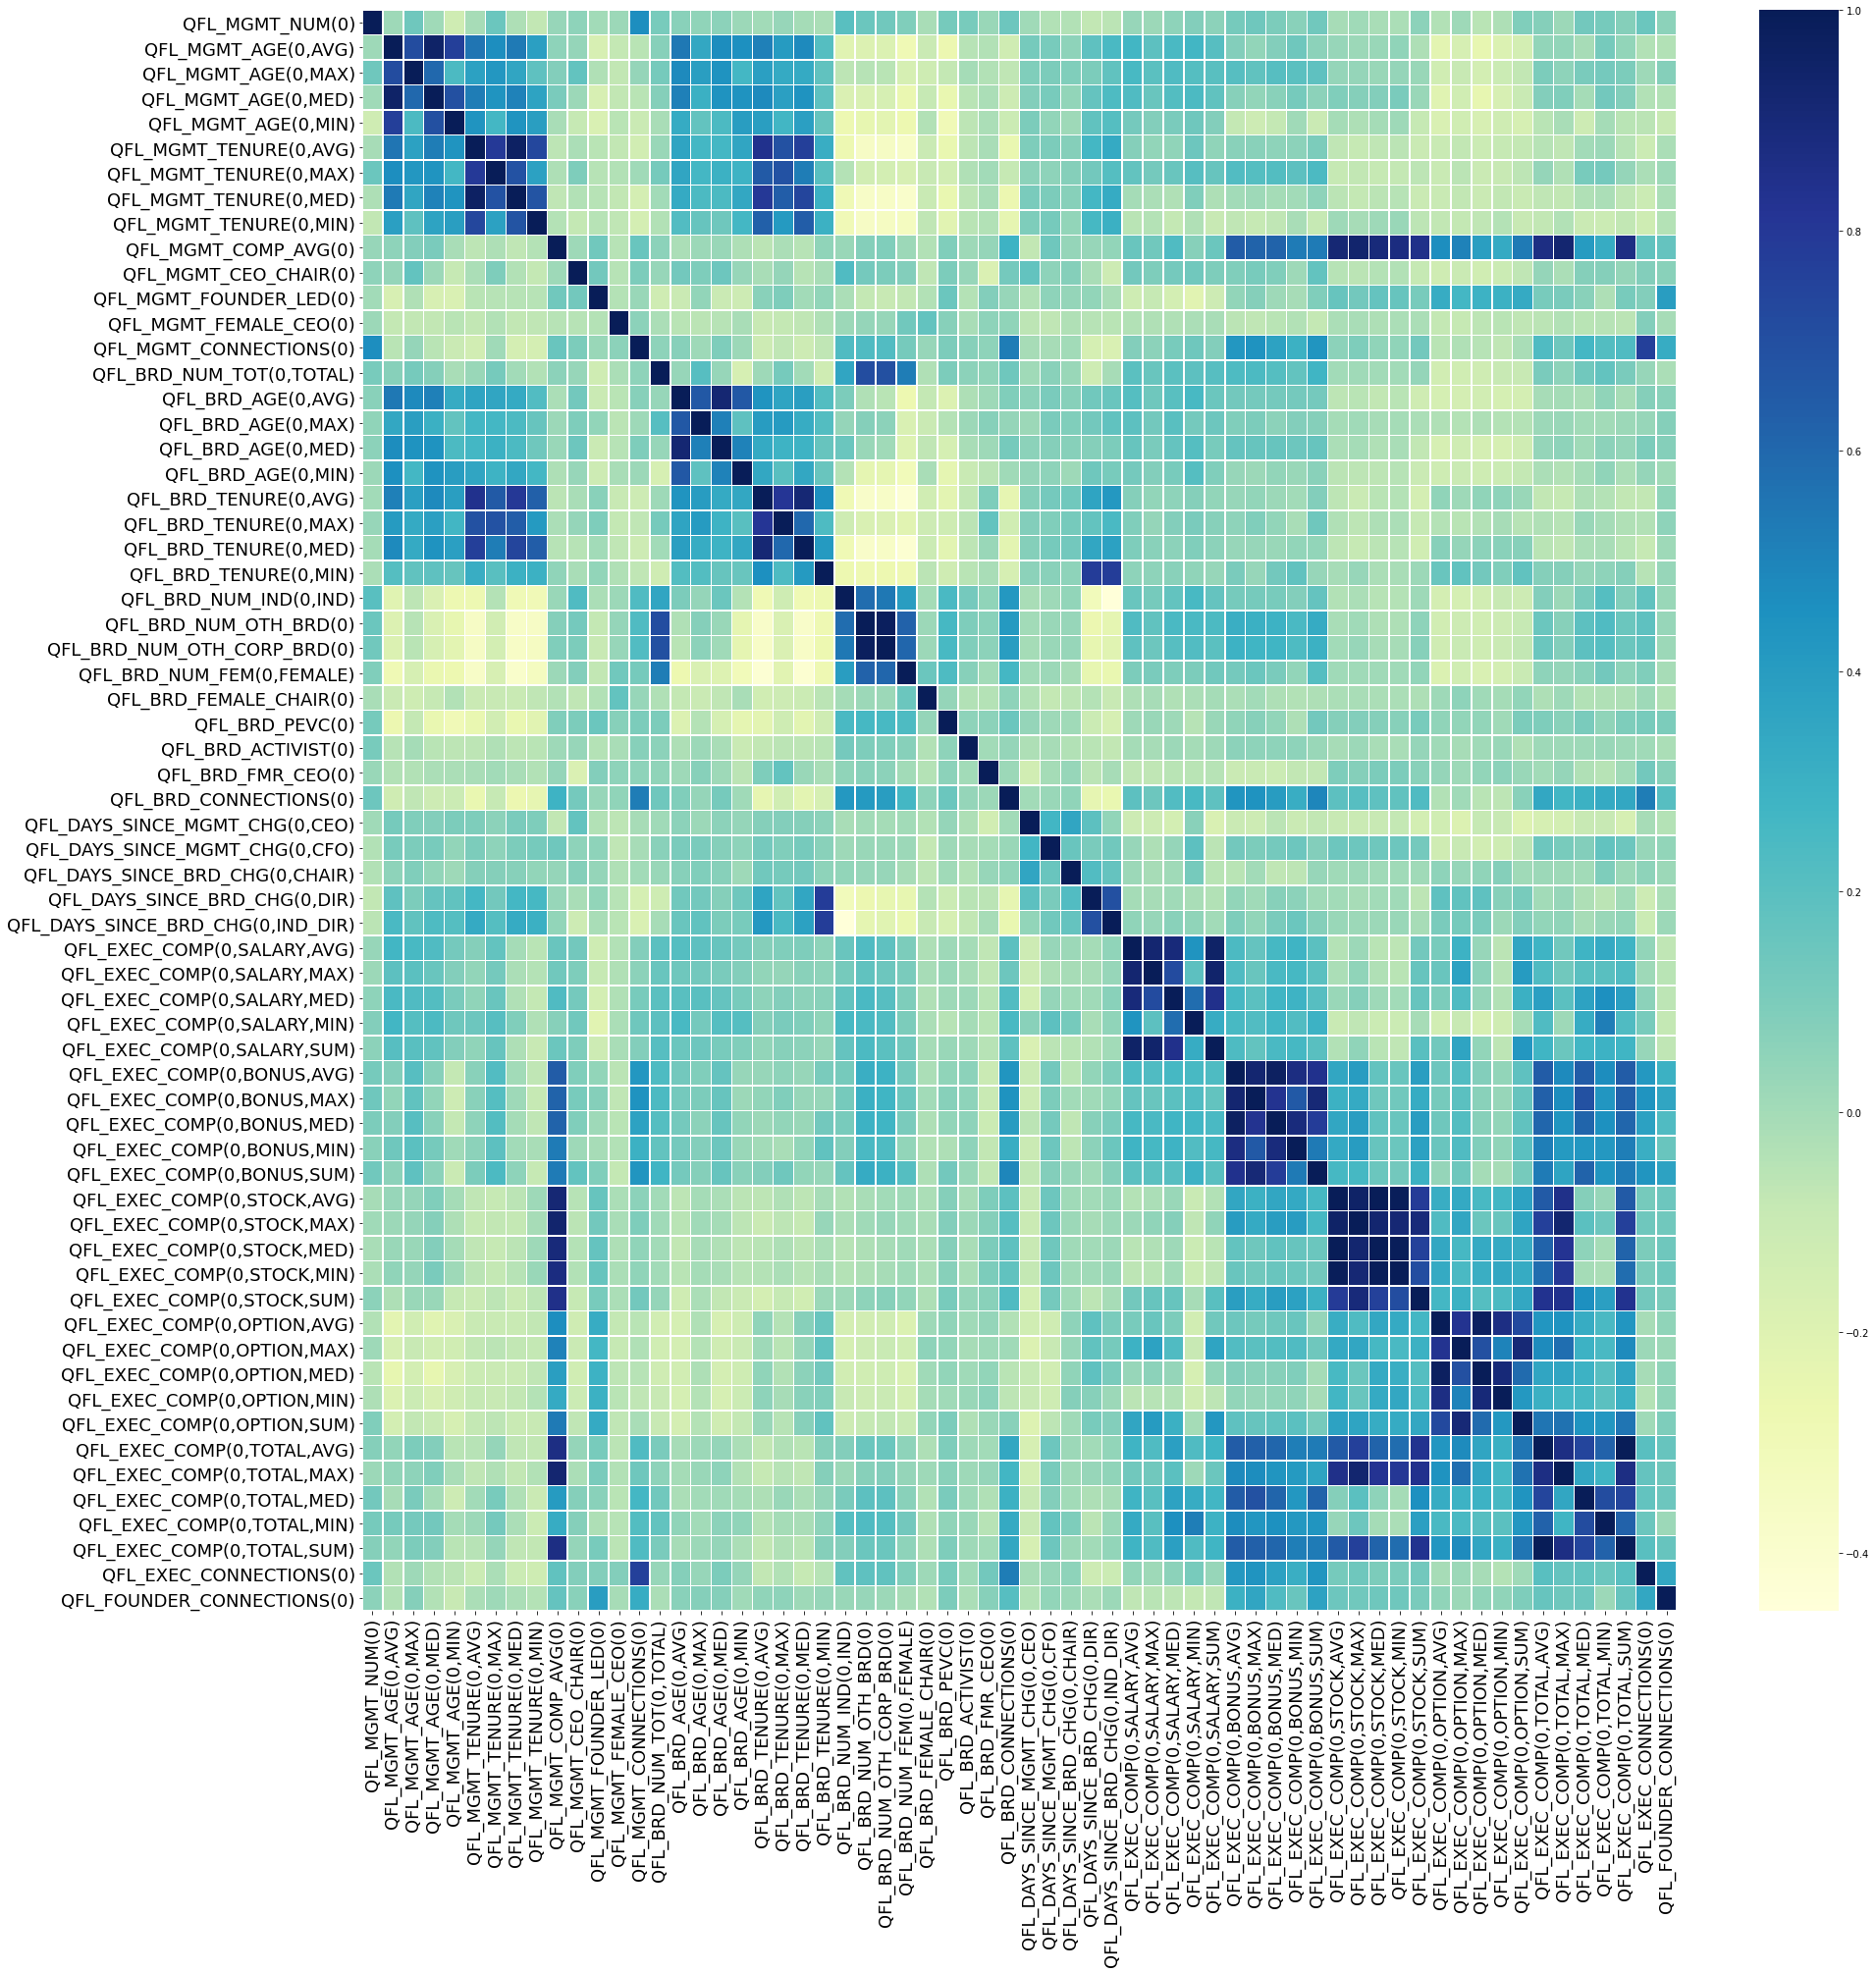

In [50]:
## Plot the correlation between each pair of factors

fig, ax = plt.subplots(figsize=(30,30))
hm = sns.heatmap(qfl_df[[c for c in qfl_df.columns[filter_idx]]].corr(), cmap="YlGnBu", annot = False, linewidths=.5, ax = ax)
hm.set_yticklabels(hm.get_ymajorticklabels(), fontsize = 18, rotation=0)
hm.set_xticklabels(hm.get_xmajorticklabels(), fontsize = 18, rotation=90)
plt.show()

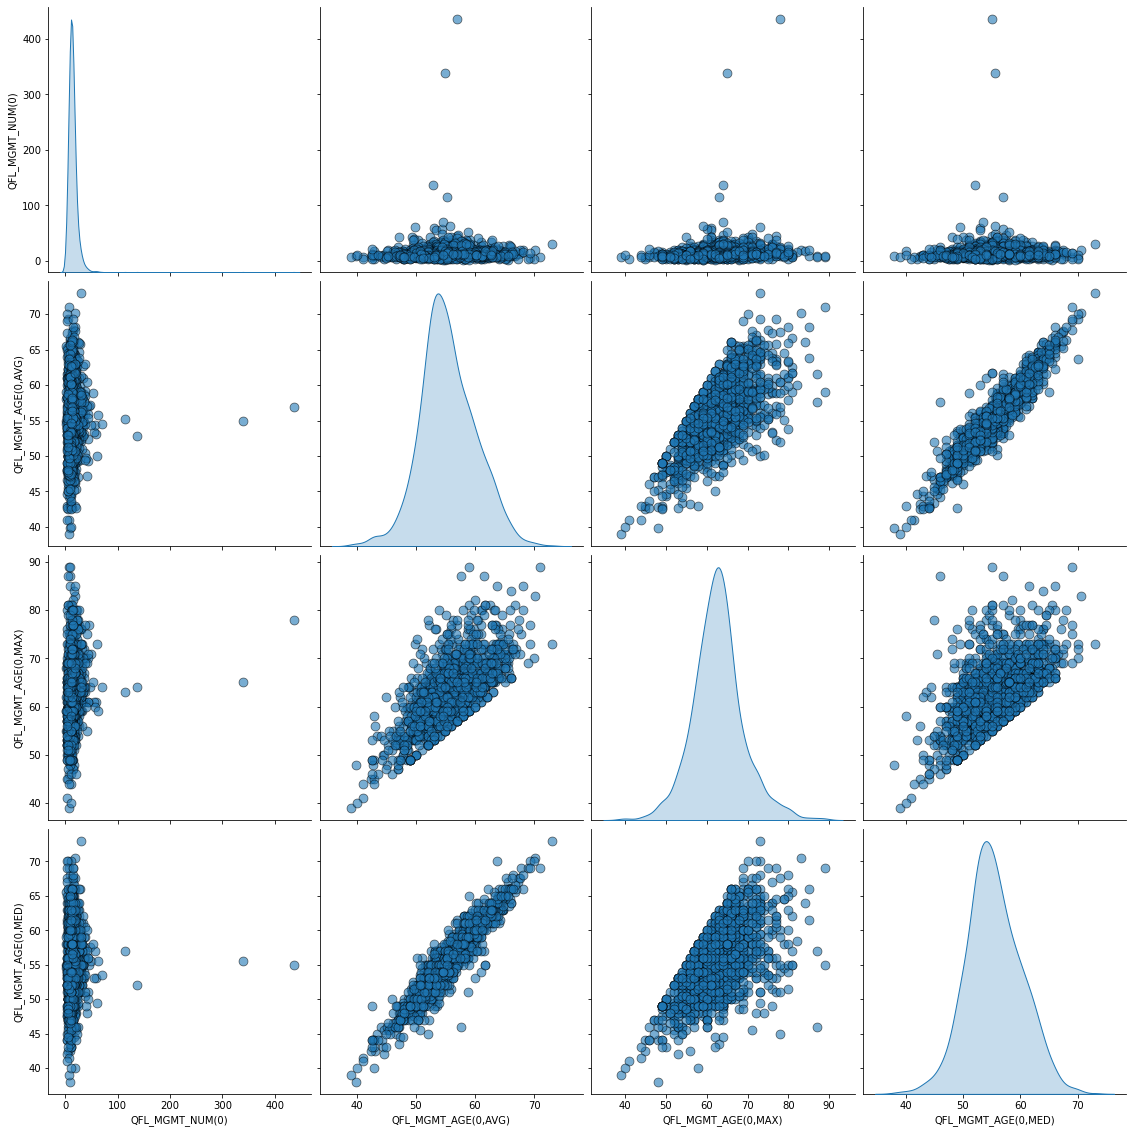

In [14]:
# Pairplot

sns.pairplot(qfl_df[qfl_df.columns[filter_idx[:4]].values], diag_kind = 'kde',
             plot_kws = {'alpha': 0.6, 's': 80, 'edgecolor': 'k'}, height = 4);
#plt.show()

In [15]:
qfl_df[qfl_df.columns[filter_idx[:4]].values]

,QFL_MGMT_NUM(0),"QFL_MGMT_AGE(0,AVG)","QFL_MGMT_AGE(0,MAX)","QFL_MGMT_AGE(0,MED)"
0,31.0,53.00,59.0,55.0
1,59.0,53.10,61.0,53.0
2,27.0,53.50,56.0,54.0
3,42.0,47.12,55.0,48.0
4,7.0,58.20,68.0,62.0
...,...,...,...,...
1595,18.0,61.75,68.0,61.5
1596,10.0,62.67,69.0,63.0
1597,6.0,48.00,51.0,48.0
1598,11.0,60.17,65.0,61.5


In [16]:
# Other Statistics

advanced_describe = {}
stats_table = pd.DataFrame()
for factor in list(qfl_df.columns[filter_idx].values):
    advanced_describe[factor] = stats.describe(qfl_df[factor].dropna(), axis=0)    
    adv_stats = {keys: [np.round(series, 2) for series in values] for (keys, values) in zip(advanced_describe.keys(), advanced_describe.values())}
    stats_table = pd.DataFrame(adv_stats, index=['nobs', 'minmax', 'mean', 'variance', 'skewness', 'kurtosis']).T
stats_table

,nobs,minmax,mean,variance,skewness,kurtosis
QFL_MGMT_NUM(0),1596,"[1.0, 436.0]",14.36,246.79,18.31,440.83
"QFL_MGMT_AGE(0,AVG)",1578,"[39.0, 73.0]",55.42,21.73,0.17,0.41
"QFL_MGMT_AGE(0,MAX)",1578,"[39.0, 89.0]",62.73,38.75,0.35,1.42
"QFL_MGMT_AGE(0,MED)",1578,"[38.0, 73.0]",55.41,23.52,0.12,0.23
"QFL_MGMT_AGE(0,MIN)",1578,"[24.0, 73.0]",48.12,40.96,0.2,0.01
...,...,...,...,...,...,...
"QFL_EXEC_COMP(0,TOTAL,MED)",625,"[258554.0, 55962690.0]",5.20709e+06,1.82365e+13,4.54,38.02
"QFL_EXEC_COMP(0,TOTAL,MIN)",625,"[1.0, 19136744.0]",3.14728e+06,5.63863e+12,2.06,6.74
"QFL_EXEC_COMP(0,TOTAL,SUM)",625,"[479354.75, 56389292.0]",7.10362e+06,3.03251e+13,4.09,26.86
QFL_EXEC_CONNECTIONS(0),1598,"[0.0, 9119.0]",273.69,333949,6.44,64.44


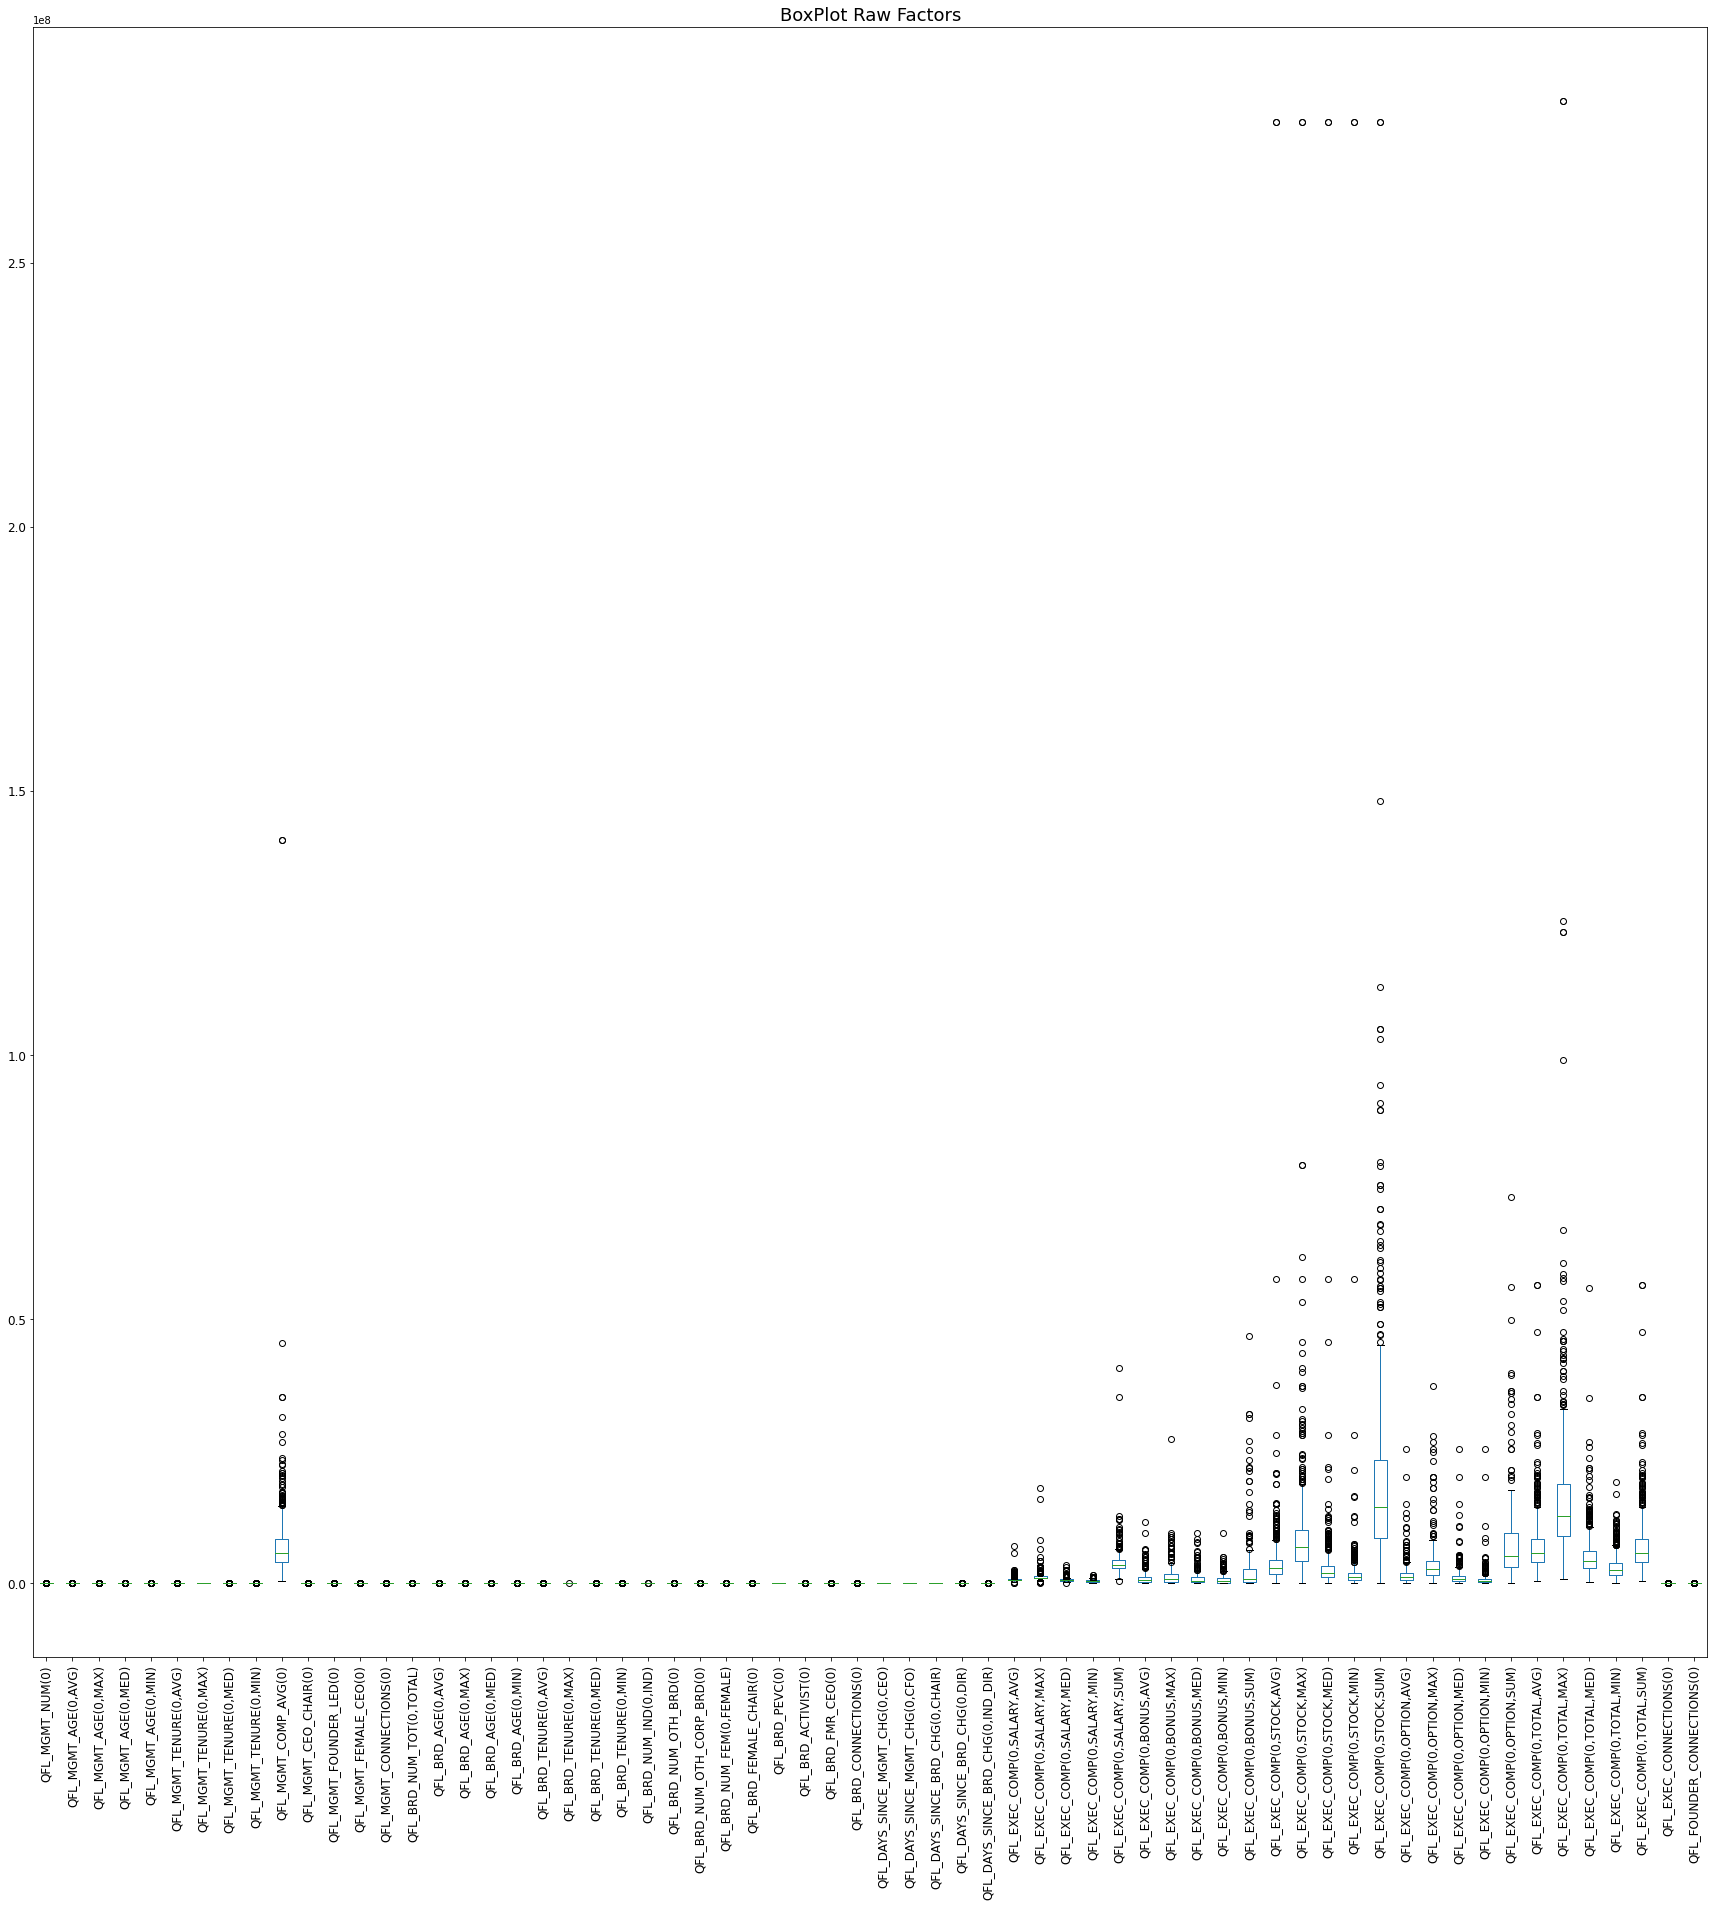

In [17]:
# Box-Whisker plot

qfl_df[qfl_df.columns[filter_idx]].boxplot(grid=False, rot=90, fontsize=12, figsize = (30,30)).set_title('BoxPlot Raw Factors', fontsize = 18);

In [18]:
# Z-Score

qfl_df_z = pd.DataFrame()

for factor in qfl_df[qfl_df.columns[filter_idx]]:
    z_score = ( qfl_df[factor] - qfl_df[factor].mean() ) / qfl_df[factor].std()
    qfl_df_z[factor] = z_score

qfl_df_z.describe()

,QFL_MGMT_NUM(0),"QFL_MGMT_AGE(0,AVG)","QFL_MGMT_AGE(0,MAX)","QFL_MGMT_AGE(0,MED)","QFL_MGMT_AGE(0,MIN)","QFL_MGMT_TENURE(0,AVG)","QFL_MGMT_TENURE(0,MAX)","QFL_MGMT_TENURE(0,MED)","QFL_MGMT_TENURE(0,MIN)",QFL_MGMT_COMP_AVG(0),QFL_MGMT_CEO_CHAIR(0),QFL_MGMT_FOUNDER_LED(0),QFL_MGMT_FEMALE_CEO(0),QFL_MGMT_CONNECTIONS(0),"QFL_BRD_NUM_TOT(0,TOTAL)","QFL_BRD_AGE(0,AVG)","QFL_BRD_AGE(0,MAX)","QFL_BRD_AGE(0,MED)","QFL_BRD_AGE(0,MIN)","QFL_BRD_TENURE(0,AVG)","QFL_BRD_TENURE(0,MAX)","QFL_BRD_TENURE(0,MED)","QFL_BRD_TENURE(0,MIN)","QFL_BRD_NUM_IND(0,IND)",QFL_BRD_NUM_OTH_BRD(0),QFL_BRD_NUM_OTH_CORP_BRD(0),"QFL_BRD_NUM_FEM(0,FEMALE)",QFL_BRD_FEMALE_CHAIR(0),QFL_BRD_PEVC(0),QFL_BRD_ACTIVIST(0),QFL_BRD_FMR_CEO(0),QFL_BRD_CONNECTIONS(0),"QFL_DAYS_SINCE_MGMT_CHG(0,CEO)","QFL_DAYS_SINCE_MGMT_CHG(0,CFO)","QFL_DAYS_SINCE_BRD_CHG(0,CHAIR)","QFL_DAYS_SINCE_BRD_CHG(0,DIR)","QFL_DAYS_SINCE_BRD_CHG(0,IND_DIR)","QFL_EXEC_COMP(0,SALARY,AVG)","QFL_EXEC_COMP(0,SALARY,MAX)","QFL_EXEC_COMP(0,SALARY,MED)","QFL_EXEC_COMP(0,SALARY,MIN)","QFL_EXEC_COMP(0,SALARY,SUM)","QFL_EXEC_COMP(0,BONUS,AVG)","QFL_EXEC_COMP(0,BONUS,MAX)","QFL_EXEC_COMP(0,BONUS,MED)","QFL_EXEC_COMP(0,BONUS,MIN)","QFL_EXEC_COMP(0,BONUS,SUM)","QFL_EXEC_COMP(0,STOCK,AVG)","QFL_EXEC_COMP(0,STOCK,MAX)","QFL_EXEC_COMP(0,STOCK,MED)","QFL_EXEC_COMP(0,STOCK,MIN)","QFL_EXEC_COMP(0,STOCK,SUM)","QFL_EXEC_COMP(0,OPTION,AVG)","QFL_EXEC_COMP(0,OPTION,MAX)","QFL_EXEC_COMP(0,OPTION,MED)","QFL_EXEC_COMP(0,OPTION,MIN)","QFL_EXEC_COMP(0,OPTION,SUM)","QFL_EXEC_COMP(0,TOTAL,AVG)","QFL_EXEC_COMP(0,TOTAL,MAX)","QFL_EXEC_COMP(0,TOTAL,MED)","QFL_EXEC_COMP(0,TOTAL,MIN)","QFL_EXEC_COMP(0,TOTAL,SUM)",QFL_EXEC_CONNECTIONS(0),QFL_FOUNDER_CONNECTIONS(0)
count,1.596000e+03,1.578000e+03,1.578000e+03,1.578000e+03,1.578000e+03,1.595000e+03,1.595000e+03,1.595000e+03,1.595000e+03,6.240000e+02,1.598000e+03,1.598000e+03,1.598000e+03,1.598000e+03,1.596000e+03,1.586000e+03,1.586000e+03,1.586000e+03,1.586000e+03,1.587000e+03,1.587000e+03,1.587000e+03,1.587000e+03,1.596000e+03,1.596000e+03,1.596000e+03,1.596000e+03,1.598000e+03,1.598000e+03,1.598000e+03,1.598000e+03,1.598000e+03,9.140000e+02,9.890000e+02,8.610000e+02,1.140000e+03,9.060000e+02,6.230000e+02,6.230000e+02,6.230000e+02,6.230000e+02,6.230000e+02,2.420000e+02,2.420000e+02,2.420000e+02,2.420000e+02,2.420000e+02,5.990000e+02,5.990000e+02,5.990000e+02,5.990000e+02,5.990000e+02,3.290000e+02,3.290000e+02,3.290000e+02,3.290000e+02,3.290000e+02,6.250000e+02,6.250000e+02,6.250000e+02,6.250000e+02,6.250000e+02,1.598000e+03,1.598000e+03
mean,6.577863e-16,-1.588365e-15,2.541271e-16,1.152437e-16,1.950981e-15,1.538581e-15,-5.812000e-15,7.586269e-15,1.113355e-15,-2.601818e-15,-3.638030e-15,-1.496300e-15,1.526730e-16,1.622954e-16,-3.995690e-16,-1.210017e-14,5.033629e-16,-5.070905e-16,-5.016654e-16,1.726547e-16,2.325802e-15,1.962723e-15,3.937199e-16,1.567529e-15,-1.752427e-15,-1.188829e-15,1.565999e-15,-2.144717e-16,2.784728e-15,-4.623613e-17,4.482925e-16,3.746134e-16,6.425689e-17,2.146918e-17,2.920622e-17,-2.587599e-16,9.435670e-18,1.207167e-15,-1.165467e-16,1.881855e-16,-9.730044e-17,-8.126191e-17,2.773981e-16,1.618311e-16,1.414732e-16,1.926833e-17,-1.720387e-18,-1.356733e-15,4.661454e-17,-1.668115e-17,-3.229655e-17,-1.252940e-16,-3.502771e-16,4.724353e-18,-3.155193e-17,9.111253e-18,-3.644501e-17,-3.039169e-15,5.346834e-17,-6.785683e-17,4.263256e-17,-3.039169e-15,-6.749572e-17,2.924930e-16
std,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000

In [19]:
# look for "extremely large" column's values after normalization (Descending)

for col_z in qfl_df_z:
    qfl_df_z[col_z] = qfl_df_z[col_z].sort_values(ignore_index=True, ascending = False)
    
qfl_df_z

,QFL_MGMT_NUM(0),"QFL_MGMT_AGE(0,AVG)","QFL_MGMT_AGE(0,MAX)","QFL_MGMT_AGE(0,MED)","QFL_MGMT_AGE(0,MIN)","QFL_MGMT_TENURE(0,AVG)","QFL_MGMT_TENURE(0,MAX)","QFL_MGMT_TENURE(0,MED)","QFL_MGMT_TENURE(0,MIN)",QFL_MGMT_COMP_AVG(0),QFL_MGMT_CEO_CHAIR(0),QFL_MGMT_FOUNDER_LED(0),QFL_MGMT_FEMALE_CEO(0),QFL_MGMT_CONNECTIONS(0),"QFL_BRD_NUM_TOT(0,TOTAL)","QFL_BRD_AGE(0,AVG)","QFL_BRD_AGE(0,MAX)","QFL_BRD_AGE(0,MED)","QFL_BRD_AGE(0,MIN)","QFL_BRD_TENURE(0,AVG)","QFL_BRD_TENURE(0,MAX)","QFL_BRD_TENURE(0,MED)","QFL_BRD_TENURE(0,MIN)","QFL_BRD_NUM_IND(0,IND)",QFL_BRD_NUM_OTH_BRD(0),QFL_BRD_NUM_OTH_CORP_BRD(0),"QFL_BRD_NUM_FEM(0,FEMALE)",QFL_BRD_FEMALE_CHAIR(0),QFL_BRD_PEVC(0),QFL_BRD_ACTIVIST(0),QFL_BRD_FMR_CEO(0),QFL_BRD_CONNECTIONS(0),"QFL_DAYS_SINCE_MGMT_CHG(0,CEO)","QFL_DAYS_SINCE_MGMT_CHG(0,CFO)","QFL_DAYS_SINCE_BRD_CHG(0,CHAIR)","QFL_DAYS_SINCE_BRD_CHG(0,DIR)","QFL_DAYS_SINCE_BRD_CHG(0,IND_DIR)","QFL_EXEC_COMP(0,SALARY,AVG)","QFL_EXEC_COMP(0,SALARY,MAX)","QFL_EXEC_COMP(0,SALARY,MED)","QFL_EXEC_COMP(0,SALARY,MIN)","QFL_EXEC_COMP(0,SALARY,SUM)","QFL_EXEC_COMP(0,BONUS,AVG)","QFL_EXEC_COMP(0,BONUS,MAX)","QFL_EXEC_COMP(0,BONUS,MED)","QFL_EXEC_COMP(0,BONUS,MIN)","QFL_EXEC_COMP(0,BONUS,SUM)","QFL_EXEC_COMP(0,STOCK,AVG)","QFL_EXEC_COMP(0,STOCK,MAX)","QFL_EXEC_COMP(0,STOCK,MED)","QFL_EXEC_COMP(0,STOCK,MIN)","QFL_EXEC_COMP(0,STOCK,SUM)","QFL_EXEC_COMP(0,OPTION,AVG)","QFL_EXEC_COMP(0,OPTION,MAX)","QFL_EXEC_COMP(0,OPTION,MED)","QFL_EXEC_COMP(0,OPTION,MIN)","QFL_EXEC_COMP(0,OPTION,SUM)","QFL_EXEC_COMP(0,TOTAL,AVG)","QFL_EXEC_COMP(0,TOTAL,MAX)","QFL_EXEC_COMP(0,TOTAL,MED)","QFL_EXEC_COMP(0,TOTAL,MIN)","QFL_EXEC_COMP(0,TOTAL,SUM)",QFL_EXEC_CONNECTIONS(0),QFL_FOUNDER_CONNECTIONS(0)
0,26.839861,3.771185,4.219704,3.628077,3.887826,3.376759,2.758873,3.210862,5.143802,14.899894,1.837381,2.689346,4.383585,12.371431,5.145967,3.549371,4.077497,3.472771,2.807752,4.430515,3.253021,4.547142,19.279080,3.868426,4.894090,5.089245,5.723215,3.954244,1.173505,6.680509,2.075156,6.646805,2.009747,2.046445,1.959022,4.831381,2.811616,14.715062,15.405886,9.550190,5.092314,14.804597,6.902608,9.953097,5.836786,7.961218,6.910958,16.681653,15.177890,16.739887,16.928940,11.185680,9.311415,7.252337,10.039800,11.888900,7.730338,8.949923,13.554474,11.885395,6.733599,8.949923,15.306383,17.735762
1,20.665265,3.342161,4.219704,3.112552,3.419065,3.321100,2.739342,3.160755,4.870353,14.899894,1.837381,2.689346,4.383585,10.388864,5.145967,3.136832,3.908652,3.360125,2.498584,4.219255,3.044519,4.443926,10.020910,3.868426,3.979920,4.157880,5.157802,3.954244,1.173505,6.680509,2.075156,6.025061,2.009747,2.046445,1.953641,4.737237,2.811616,11.858721,13.568967,8.079372,4.604205,12.589820,5.477927,3.062697,5.012297,3.853613,4.571517,16.681653,15.177890,16.739887,16.928940,11.185680,7.205784,5.171641,7.811419,9.298204,5.703355,8.949923,13.554474,6.998208,5.808271,8.949923,12.066976,16.289154
2,7.806828,3.164117,3.898424,3.009447,3.262811,3.274003,2.739342,3.044767,4.733629,4.246806,1.837381,2.689346,4.383585,10.295711,4.502797,3.032484,3.908652,3.360125,2.498584,4.112916,2.975018,4.217079,7.810677,3.561551,3.979920,4.157880,4.026975,3.954244,1.173505,6.680509,2.075156,5.688533,2.005394,2.046445,1.953641,4.554833,2.799788,3.979872,6.441010,6.278831,3.572469,3.518093,3.503030,2.892823,4.707877,3.853613,4.566948,3.240892,3.957289,3.300925,3.391659,5.581327,5.179164,4.950432,5.666655,4.800534,4.968970,7.339377,5.592846,5.056271,4.206186,7.339377,10.464577,13.240945
3,6.342749,3.127650,3.898424,3.009447,2.794050,3.261158,2.576589,2.975175,4.733629,3.121373,1.837381,2.689346,4.383585,9.242912,4.181212,2.916003,3.570963,2.909542,2.498584,4.022173,2.842271,4.046943,7.438546,2.947802,3.370474,3.536970,3.461562,3.954244,1.173505,6.680509,2.075156,5.329348,2.001041,2.046445,1.944673,4.195908,2.754450,3.979872,4.773785,6.278831,3.572469,3.340552,3.455719,2.773140,4.565698,3.488492,4.472339,2.016154,3.957289,2.575213,1.571512,4.046597,4.510790,4.667583,4.840041,3.701071,3.793123,5.129140,5.481027,4.830010,4.

In [20]:
# look for "extremely large" column's values after normalization (Ascending)

for col_z in qfl_df_z:
    qfl_df_z[col_z] = qfl_df_z[col_z].sort_values(ignore_index=True, ascending = True)
    
qfl_df_z

,QFL_MGMT_NUM(0),"QFL_MGMT_AGE(0,AVG)","QFL_MGMT_AGE(0,MAX)","QFL_MGMT_AGE(0,MED)","QFL_MGMT_AGE(0,MIN)","QFL_MGMT_TENURE(0,AVG)","QFL_MGMT_TENURE(0,MAX)","QFL_MGMT_TENURE(0,MED)","QFL_MGMT_TENURE(0,MIN)",QFL_MGMT_COMP_AVG(0),QFL_MGMT_CEO_CHAIR(0),QFL_MGMT_FOUNDER_LED(0),QFL_MGMT_FEMALE_CEO(0),QFL_MGMT_CONNECTIONS(0),"QFL_BRD_NUM_TOT(0,TOTAL)","QFL_BRD_AGE(0,AVG)","QFL_BRD_AGE(0,MAX)","QFL_BRD_AGE(0,MED)","QFL_BRD_AGE(0,MIN)","QFL_BRD_TENURE(0,AVG)","QFL_BRD_TENURE(0,MAX)","QFL_BRD_TENURE(0,MED)","QFL_BRD_TENURE(0,MIN)","QFL_BRD_NUM_IND(0,IND)",QFL_BRD_NUM_OTH_BRD(0),QFL_BRD_NUM_OTH_CORP_BRD(0),"QFL_BRD_NUM_FEM(0,FEMALE)",QFL_BRD_FEMALE_CHAIR(0),QFL_BRD_PEVC(0),QFL_BRD_ACTIVIST(0),QFL_BRD_FMR_CEO(0),QFL_BRD_CONNECTIONS(0),"QFL_DAYS_SINCE_MGMT_CHG(0,CEO)","QFL_DAYS_SINCE_MGMT_CHG(0,CFO)","QFL_DAYS_SINCE_BRD_CHG(0,CHAIR)","QFL_DAYS_SINCE_BRD_CHG(0,DIR)","QFL_DAYS_SINCE_BRD_CHG(0,IND_DIR)","QFL_EXEC_COMP(0,SALARY,AVG)","QFL_EXEC_COMP(0,SALARY,MAX)","QFL_EXEC_COMP(0,SALARY,MED)","QFL_EXEC_COMP(0,SALARY,MIN)","QFL_EXEC_COMP(0,SALARY,SUM)","QFL_EXEC_COMP(0,BONUS,AVG)","QFL_EXEC_COMP(0,BONUS,MAX)","QFL_EXEC_COMP(0,BONUS,MED)","QFL_EXEC_COMP(0,BONUS,MIN)","QFL_EXEC_COMP(0,BONUS,SUM)","QFL_EXEC_COMP(0,STOCK,AVG)","QFL_EXEC_COMP(0,STOCK,MAX)","QFL_EXEC_COMP(0,STOCK,MED)","QFL_EXEC_COMP(0,STOCK,MIN)","QFL_EXEC_COMP(0,STOCK,SUM)","QFL_EXEC_COMP(0,OPTION,AVG)","QFL_EXEC_COMP(0,OPTION,MAX)","QFL_EXEC_COMP(0,OPTION,MED)","QFL_EXEC_COMP(0,OPTION,MIN)","QFL_EXEC_COMP(0,OPTION,SUM)","QFL_EXEC_COMP(0,TOTAL,AVG)","QFL_EXEC_COMP(0,TOTAL,MAX)","QFL_EXEC_COMP(0,TOTAL,MED)","QFL_EXEC_COMP(0,TOTAL,MIN)","QFL_EXEC_COMP(0,TOTAL,SUM)",QFL_EXEC_CONNECTIONS(0),QFL_FOUNDER_CONNECTIONS(0)
0,-0.850337,-3.522212,-3.812301,-3.589265,-3.768606,-1.401416,-2.089544,-1.162343,-0.553497,-0.773659,-0.543912,-0.371605,-0.227981,-0.524923,-3.536832,-4.798476,-4.702412,-4.187141,-3.839350,-1.486196,-1.732281,-1.071874,-0.832912,-1.962189,-2.723988,-2.672131,-1.627157,-0.252735,-0.851615,-0.149596,-0.481590,-0.888090,-1.555209,-1.582845,-1.685683,-1.084994,-1.190009,-1.475724,-1.034533,-1.880172,-1.938516,-1.359901,-0.706930,-0.604872,-0.690213,-0.710117,-0.501977,-0.291028,-0.541995,-0.230538,-0.166283,-0.869860,-0.712809,-0.843883,-0.568795,-0.444561,-0.910694,-1.202919,-0.801271,-1.158794,-1.325404,-1.202919,-0.473611,-0.146636
1,-0.786681,-3.350603,-3.651661,-3.383056,-2.987338,-1.401416,-2.082220,-1.161415,-0.553497,-0.755160,-0.543912,-0.371605,-0.227981,-0.524923,-3.536832,-3.941851,-3.182813,-3.736558,-3.839350,-1.466346,-1.726721,-1.062801,-0.827274,-1.962189,-2.723988,-2.672131,-1.627157,-0.252735,-0.851615,-0.149596,-0.481590,-0.888090,-1.553758,-1.572170,-1.674921,-1.061458,-1.190009,-1.357750,-0.965648,-1.628031,-1.938516,-1.252822,-0.706915,-0.604833,-0.690149,-0.710028,-0.501961,-0.289639,-0.537890,-0.229700,-0.165730,-0.865912,-0.666050,-0.807885,-0.544027,-0.438450,-0.882639,-1.170418,-0.786640,-1.157459,-1.325404,-1.170418,-0.473611,-0.146636
2,-0.786681,-3.307701,-3.491021,-3.176846,-2.831084,-1.391782,-2.082220,-1.150280,-0.553497,-0.738438,-0.543912,-0.371605,-0.227981,-0.524923,-3.536832,-3.813236,-3.013968,-3.736558,-3.375599,-1.466346,-1.715601,-1.046921,-0.821636,-1.962189,-2.723988,-2.672131,-1.627157,-0.252735,-0.851615,-0.149596,-0.481590,-0.888090,-1.531994,-1.557938,-1.669540,-1.058516,-1.186067,-1.351442,-0.920644,-1.578030,-1.938516,-1.213219,-0.706881,-0.604635,-0.690080,-0.710028,-0.501875,-0.280805,-0.528758,-0.223440,-0.165705,-0.861561,-0.663123,-0.805131,-0.532735,-0.427592,-0.871057,-1.149909,-0.773037,-1.157459,-1.325403,-1.149909,-0.473611,-0.146636
3,-0.786681,-3.093189,-3.009101,-3.176846,-2.674830,-1.391782,-2.082220,-1.142857,-0.553497,-0.718294,-0.543912,-0.371605,-0.227981,-0.524923,-3.536832,-3.536592,-2.845124,-3.736558,-3.375599,-1.445078,-1.715601,-1.028773,-0.821636,-1.962189,-2.723988,-2.672131,-1.627157,-0.252735,-0.851615,-0.149596,-0.481590,-0.888090,-1.531994,-1.557938,-1.662365,-1.055574,-1.182124,-1.246930,-0.873

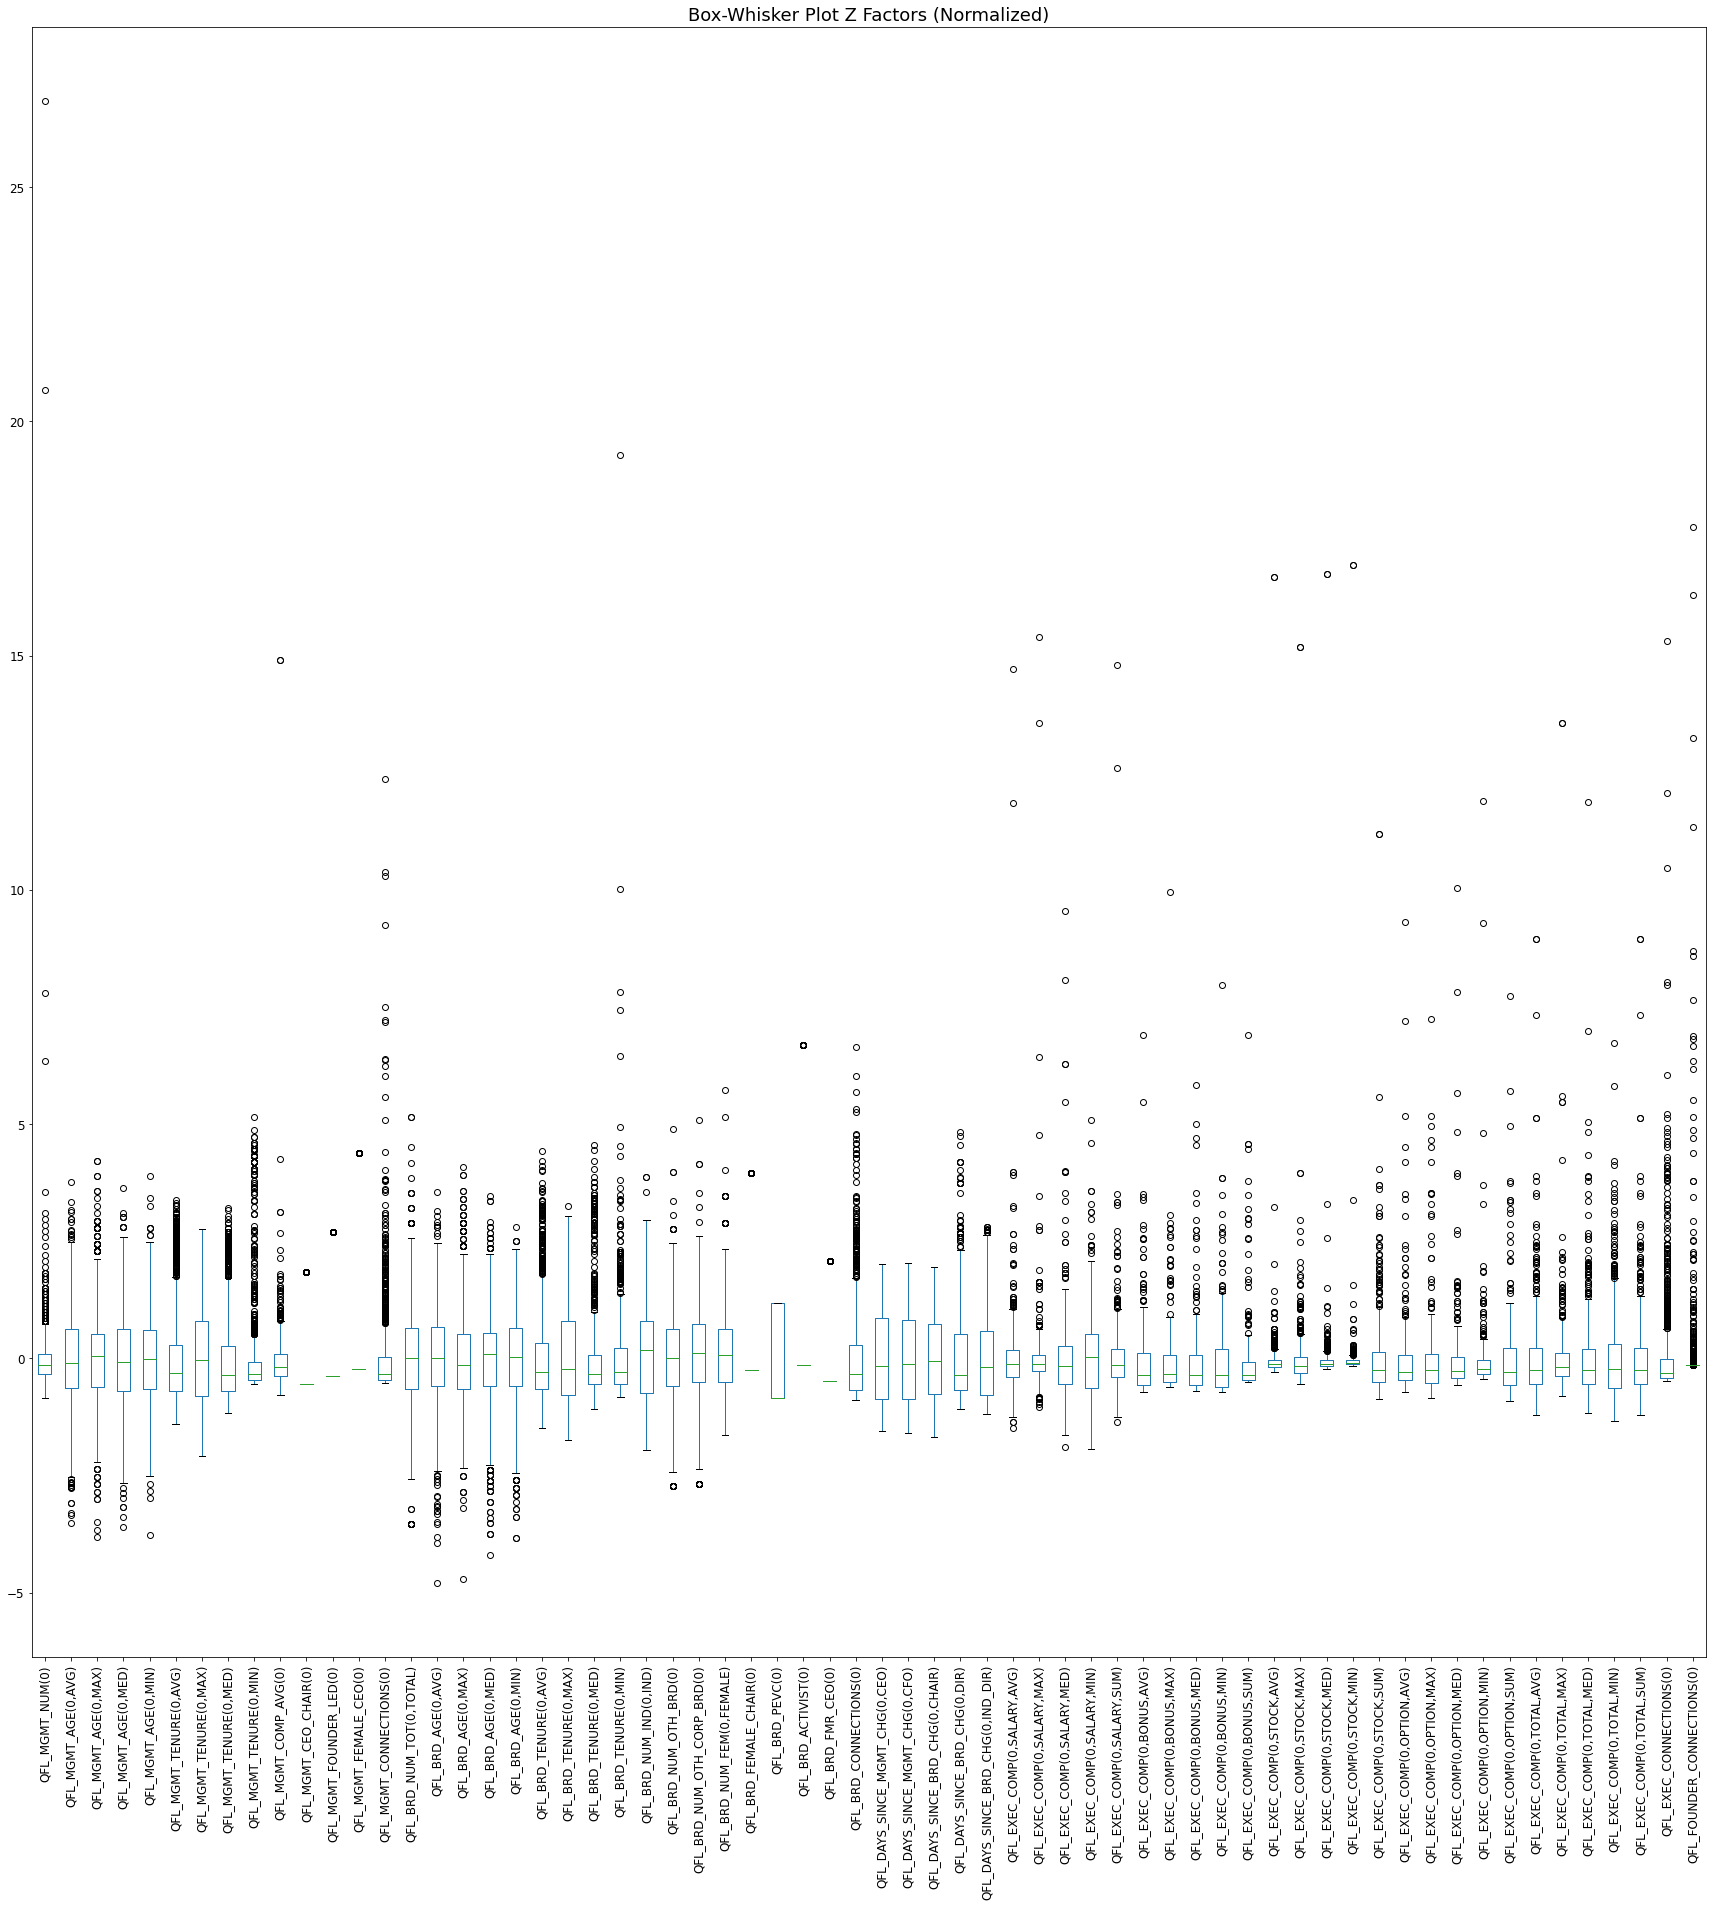

In [21]:
# Box-Whisker plot (Normalized data)

qfl_df_z.boxplot(grid=False, rot=90, fontsize=12, figsize = (30,30)).set_title('Box-Whisker Plot Z Factors (Normalized)', fontsize = 18);

In [22]:
# Greedy Multi-Factor Simple Average from all Multi-Factor's components

# MFR Z-Score

qfl_df_z['MFR'] = qfl_df_z.mean(axis = 1)

qfl_df_z.head()

,QFL_MGMT_NUM(0),"QFL_MGMT_AGE(0,AVG)","QFL_MGMT_AGE(0,MAX)","QFL_MGMT_AGE(0,MED)","QFL_MGMT_AGE(0,MIN)","QFL_MGMT_TENURE(0,AVG)","QFL_MGMT_TENURE(0,MAX)","QFL_MGMT_TENURE(0,MED)","QFL_MGMT_TENURE(0,MIN)",QFL_MGMT_COMP_AVG(0),QFL_MGMT_CEO_CHAIR(0),QFL_MGMT_FOUNDER_LED(0),QFL_MGMT_FEMALE_CEO(0),QFL_MGMT_CONNECTIONS(0),"QFL_BRD_NUM_TOT(0,TOTAL)","QFL_BRD_AGE(0,AVG)","QFL_BRD_AGE(0,MAX)","QFL_BRD_AGE(0,MED)","QFL_BRD_AGE(0,MIN)","QFL_BRD_TENURE(0,AVG)","QFL_BRD_TENURE(0,MAX)","QFL_BRD_TENURE(0,MED)","QFL_BRD_TENURE(0,MIN)","QFL_BRD_NUM_IND(0,IND)",QFL_BRD_NUM_OTH_BRD(0),QFL_BRD_NUM_OTH_CORP_BRD(0),"QFL_BRD_NUM_FEM(0,FEMALE)",QFL_BRD_FEMALE_CHAIR(0),QFL_BRD_PEVC(0),QFL_BRD_ACTIVIST(0),QFL_BRD_FMR_CEO(0),QFL_BRD_CONNECTIONS(0),"QFL_DAYS_SINCE_MGMT_CHG(0,CEO)","QFL_DAYS_SINCE_MGMT_CHG(0,CFO)","QFL_DAYS_SINCE_BRD_CHG(0,CHAIR)","QFL_DAYS_SINCE_BRD_CHG(0,DIR)","QFL_DAYS_SINCE_BRD_CHG(0,IND_DIR)","QFL_EXEC_COMP(0,SALARY,AVG)","QFL_EXEC_COMP(0,SALARY,MAX)","QFL_EXEC_COMP(0,SALARY,MED)","QFL_EXEC_COMP(0,SALARY,MIN)","QFL_EXEC_COMP(0,SALARY,SUM)","QFL_EXEC_COMP(0,BONUS,AVG)","QFL_EXEC_COMP(0,BONUS,MAX)","QFL_EXEC_COMP(0,BONUS,MED)","QFL_EXEC_COMP(0,BONUS,MIN)","QFL_EXEC_COMP(0,BONUS,SUM)","QFL_EXEC_COMP(0,STOCK,AVG)","QFL_EXEC_COMP(0,STOCK,MAX)","QFL_EXEC_COMP(0,STOCK,MED)","QFL_EXEC_COMP(0,STOCK,MIN)","QFL_EXEC_COMP(0,STOCK,SUM)","QFL_EXEC_COMP(0,OPTION,AVG)","QFL_EXEC_COMP(0,OPTION,MAX)","QFL_EXEC_COMP(0,OPTION,MED)","QFL_EXEC_COMP(0,OPTION,MIN)","QFL_EXEC_COMP(0,OPTION,SUM)","QFL_EXEC_COMP(0,TOTAL,AVG)","QFL_EXEC_COMP(0,TOTAL,MAX)","QFL_EXEC_COMP(0,TOTAL,MED)","QFL_EXEC_COMP(0,TOTAL,MIN)","QFL_EXEC_COMP(0,TOTAL,SUM)",QFL_EXEC_CONNECTIONS(0),QFL_FOUNDER_CONNECTIONS(0),MFR
0,-0.850337,-3.522212,-3.812301,-3.589265,-3.768606,-1.401416,-2.089544,-1.162343,-0.553497,-0.773659,-0.543912,-0.371605,-0.227981,-0.524923,-3.536832,-4.798476,-4.702412,-4.187141,-3.839350,-1.486196,-1.732281,-1.071874,-0.832912,-1.962189,-2.723988,-2.672131,-1.627157,-0.252735,-0.851615,-0.149596,-0.48159,-0.88809,-1.555209,-1.582845,-1.685683,-1.084994,-1.190009,-1.475724,-1.034533,-1.880172,-1.938516,-1.359901,-0.706930,-0.604872,-0.690213,-0.710117,-0.501977,-0.291028,-0.541995,-0.230538,-0.166283,-0.869860,-0.712809,-0.843883,-0.568795,-0.444561,-0.910694,-1.202919,-0.801271,-1.158794,-1.325404,-1.202919,-0.473611,-0.146636,-1.420029
1,-0.786681,-3.350603,-3.651661,-3.383056,-2.987338,-1.401416,-2.082220,-1.161415,-0.553497,-0.755160,-0.543912,-0.371605,-0.227981,-0.524923,-3.536832,-3.941851,-3.182813,-3.736558,-3.839350,-1.466346,-1.726721,-1.062801,-0.827274,-1.962189,-2.723988,-2.672131,-1.627157,-0.252735,-0.851615,-0.149596,-0.48159,-0.88809,-1.553758,-1.572170,-1.674921,-1.061458,-1.190009,-1.357750,-0.965648,-1.628031,-1.938516,-1.252822,-0.706915,-0.604833,-0.690149,-0.710028,-0.501961,-0.289639,-0.537890,-0.229700,-0.165730,-0.865912,-0.666050,-0.807885,-0.544027,-0.438450,-0.882639,-1.170418,-0.786640,-1.157459,-1.325404,-1.170418,-0.473611,-0.146636,-1.340290
2,-0.786681,-3.307701,-3.491021,-3.176846,-2.831084,-1.391782,-2.082220,-1.150280,-0.553497,-0.738438,-0.543912,-0.371605,-0.227981,-0.524923,-3.536832,-3.813236,-3.013968,-3.736558,-3.375599,-1.466346,-1.715601,-1.046921,-0.821636,-1.962189,-2.723988,-2.672131,-1.627157,-0.252735,-0.851615,-0.149596,-0.48159,-0.88809,-1.531994,-1.557938,-1.669540,-1.058516,-1.186067,-1.351442,-0.920644,-1.578030,-1.938516,-1.213219,-0.706881,-0.604635,-0.690080,-0.710028,-0.501875,-0.280805,-0.528758,-0.223440,-0.165705,-0.861561,-0.663123,-0.805131,-0.532735,-0.427592,-0.871057,-1.149909,-0.773037,-1.157459,-1.325403,-1.149909,-0.473611,-0.146636,-1.313579
3,-0.786681,-3.093189,-3.009101,-3.176846,-2.674830,-1.391782,-2.082220,-1.142857,-0.553497,-0.718294,-0.543912,-0.371605,-0.227981,-0.524923,-3.536832,-3.536592,-2.845124,-3.736558,-3.375599,-1.445078,-1.715601,-1.028773,-0.821636,-1.962189,-2.723988,-2.672131,-1.627157,-0.252735,-0.851615,-0.149596,-0.48159,-0.88809,-1.531994,-1.557938,-1.662365,-1.055574,

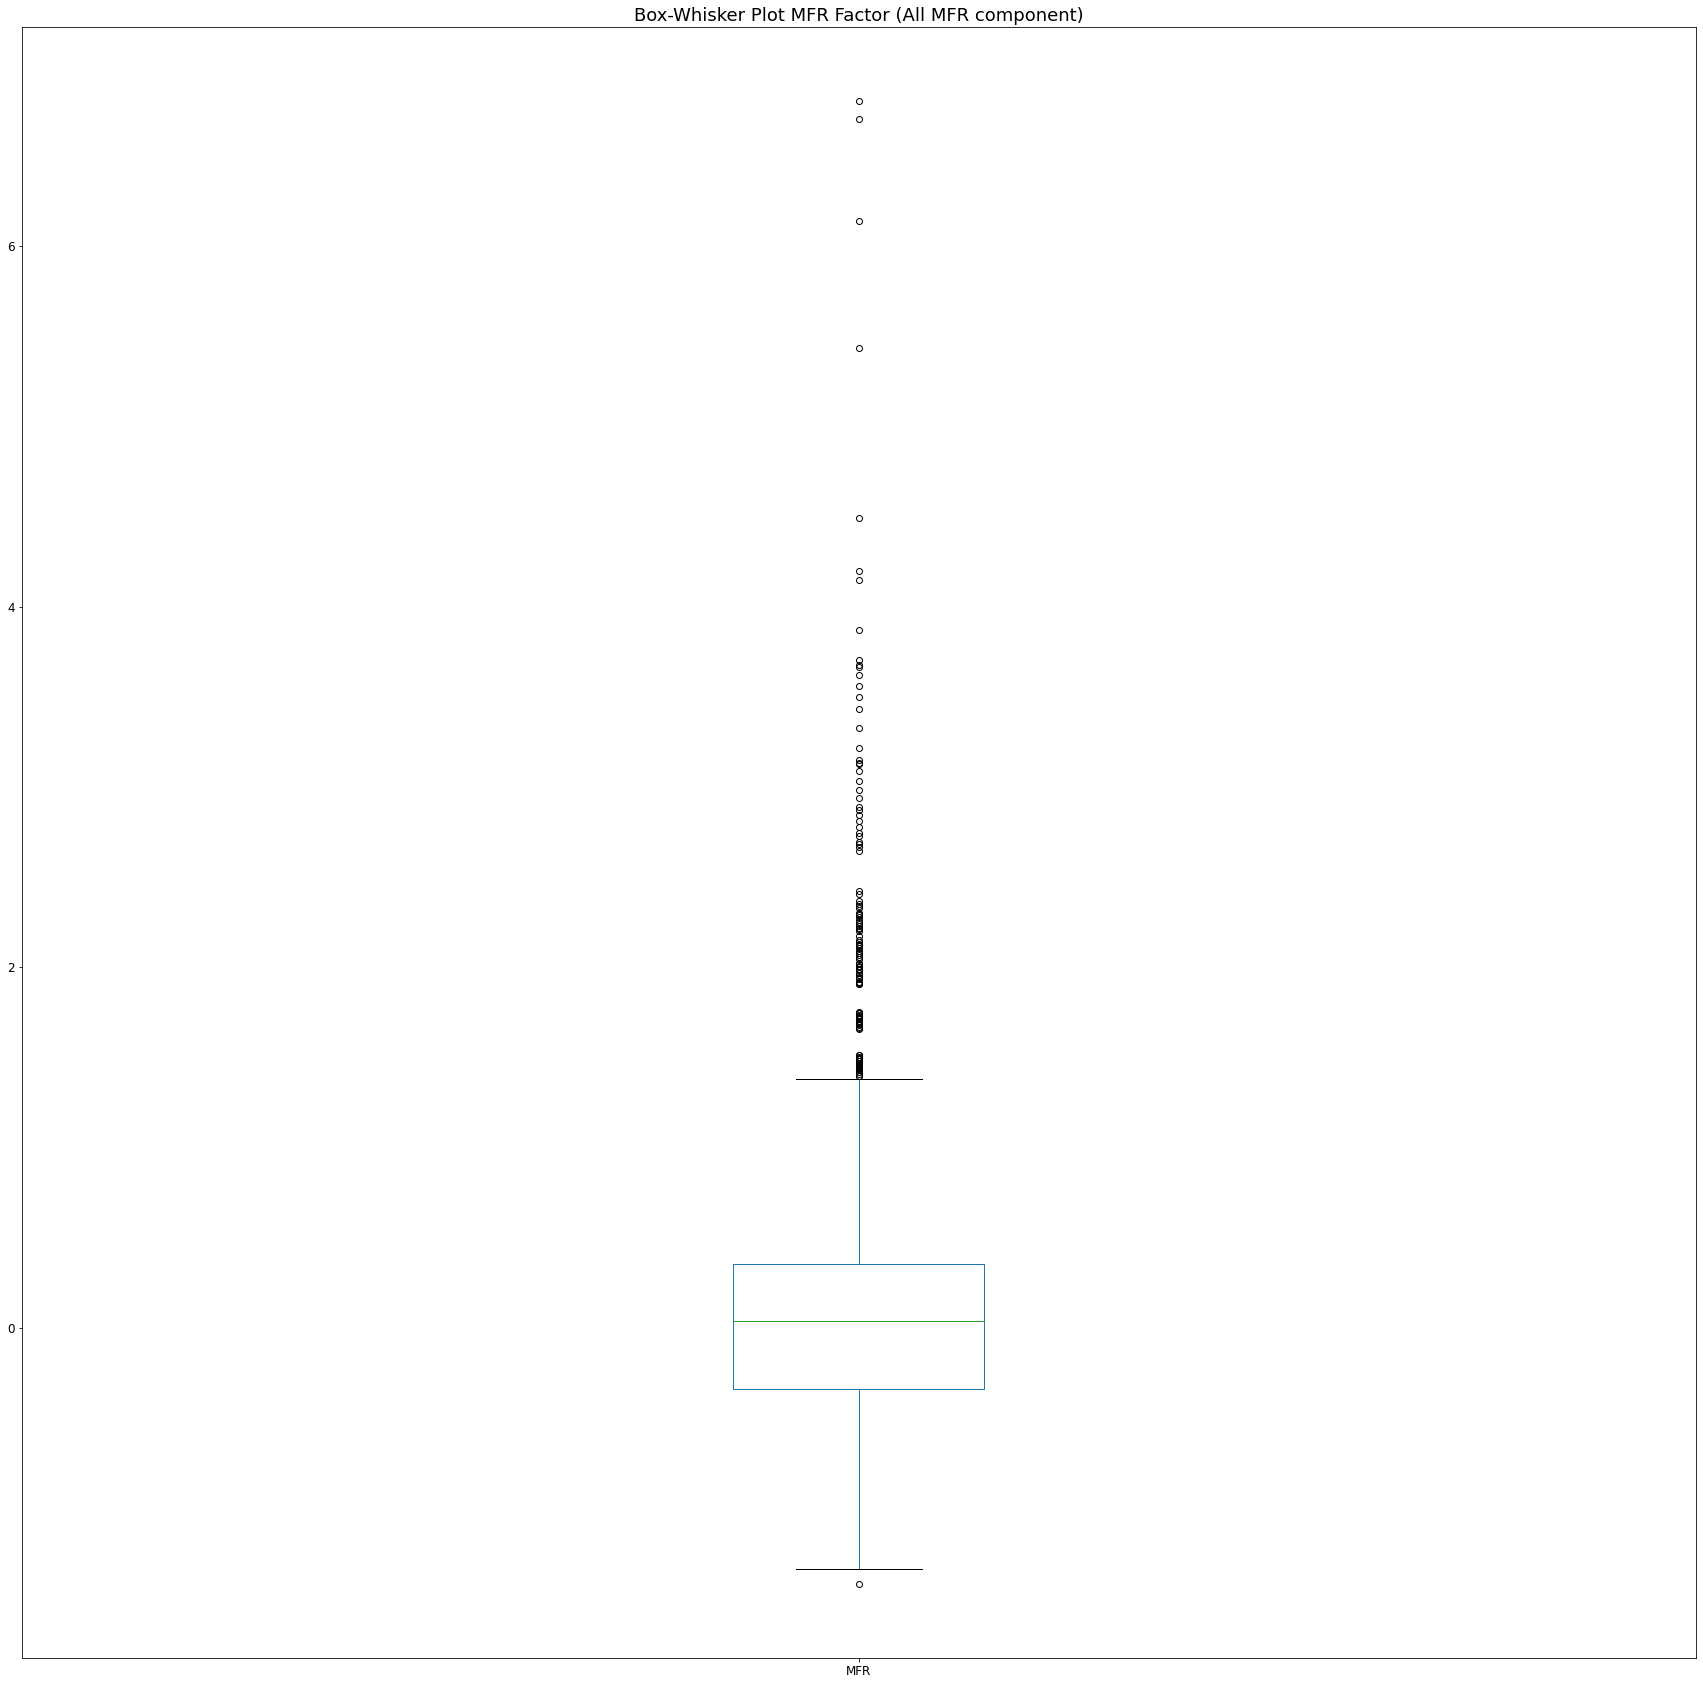

In [23]:
pd.DataFrame(qfl_df_z['MFR']).boxplot(grid=False, fontsize=12, figsize = (30,30)).set_title('Box-Whisker Plot MFR Factor (All MFR component)', fontsize = 18);

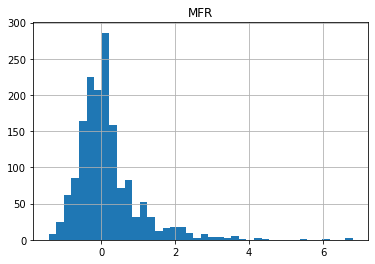

In [24]:
# MFR Distribution

pd.DataFrame(qfl_df_z['MFR']).hist(bins = int(np.sqrt(len(qfl_df_z['MFR']))));

In [25]:
# Check Infomation Coefficient: MFR (Components: All, Z-Scored Only)

sp_corr_z, sp_pval_z = stats.spearmanr(-qfl_df_z['MFR'].replace(np.nan, 0), qfl_df['p_total_return'].replace(np.nan, 0))
print('Information Coefficient: {0}'.format(round(sp_corr_z,2)))
print('Information Coefficient (P-Value): {0}'.format(round(sp_pval_z,2)))

Information Coefficient: 0.05
Information Coefficient (P-Value): 0.03


C:\Users\ffais\Anaconda3\lib\site-packages\pandas\core\series.py:726: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


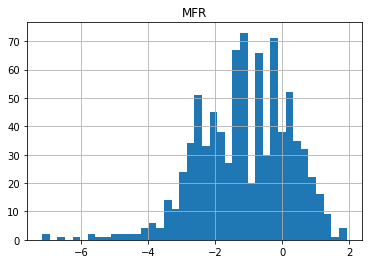

In [26]:
# MFR Log-Distribution

pd.DataFrame(np.log(qfl_df_z['MFR'])).hist(bins = int(np.sqrt(len(qfl_df_z['MFR']))));

In [27]:
# Log-Transformation for positive/not-zero features

qfl_df_log = pd.DataFrame()

for col_pos in qfl_df[qfl_df.columns[filter_idx]]:
    if np.sum(qfl_df[qfl_df.columns[filter_idx]][col_pos] <= 0) == 0:
        qfl_df_log[col_pos] = np.log(qfl_df[qfl_df.columns[filter_idx]][col_pos])
    else:
        qfl_df_log[col_pos] = qfl_df[qfl_df.columns[filter_idx]][col_pos]
    
qfl_df_log

,QFL_MGMT_NUM(0),"QFL_MGMT_AGE(0,AVG)","QFL_MGMT_AGE(0,MAX)","QFL_MGMT_AGE(0,MED)","QFL_MGMT_AGE(0,MIN)","QFL_MGMT_TENURE(0,AVG)","QFL_MGMT_TENURE(0,MAX)","QFL_MGMT_TENURE(0,MED)","QFL_MGMT_TENURE(0,MIN)",QFL_MGMT_COMP_AVG(0),QFL_MGMT_CEO_CHAIR(0),QFL_MGMT_FOUNDER_LED(0),QFL_MGMT_FEMALE_CEO(0),QFL_MGMT_CONNECTIONS(0),"QFL_BRD_NUM_TOT(0,TOTAL)","QFL_BRD_AGE(0,AVG)","QFL_BRD_AGE(0,MAX)","QFL_BRD_AGE(0,MED)","QFL_BRD_AGE(0,MIN)","QFL_BRD_TENURE(0,AVG)","QFL_BRD_TENURE(0,MAX)","QFL_BRD_TENURE(0,MED)","QFL_BRD_TENURE(0,MIN)","QFL_BRD_NUM_IND(0,IND)",QFL_BRD_NUM_OTH_BRD(0),QFL_BRD_NUM_OTH_CORP_BRD(0),"QFL_BRD_NUM_FEM(0,FEMALE)",QFL_BRD_FEMALE_CHAIR(0),QFL_BRD_PEVC(0),QFL_BRD_ACTIVIST(0),QFL_BRD_FMR_CEO(0),QFL_BRD_CONNECTIONS(0),"QFL_DAYS_SINCE_MGMT_CHG(0,CEO)","QFL_DAYS_SINCE_MGMT_CHG(0,CFO)","QFL_DAYS_SINCE_BRD_CHG(0,CHAIR)","QFL_DAYS_SINCE_BRD_CHG(0,DIR)","QFL_DAYS_SINCE_BRD_CHG(0,IND_DIR)","QFL_EXEC_COMP(0,SALARY,AVG)","QFL_EXEC_COMP(0,SALARY,MAX)","QFL_EXEC_COMP(0,SALARY,MED)","QFL_EXEC_COMP(0,SALARY,MIN)","QFL_EXEC_COMP(0,SALARY,SUM)","QFL_EXEC_COMP(0,BONUS,AVG)","QFL_EXEC_COMP(0,BONUS,MAX)","QFL_EXEC_COMP(0,BONUS,MED)","QFL_EXEC_COMP(0,BONUS,MIN)","QFL_EXEC_COMP(0,BONUS,SUM)","QFL_EXEC_COMP(0,STOCK,AVG)","QFL_EXEC_COMP(0,STOCK,MAX)","QFL_EXEC_COMP(0,STOCK,MED)","QFL_EXEC_COMP(0,STOCK,MIN)","QFL_EXEC_COMP(0,STOCK,SUM)","QFL_EXEC_COMP(0,OPTION,AVG)","QFL_EXEC_COMP(0,OPTION,MAX)","QFL_EXEC_COMP(0,OPTION,MED)","QFL_EXEC_COMP(0,OPTION,MIN)","QFL_EXEC_COMP(0,OPTION,SUM)","QFL_EXEC_COMP(0,TOTAL,AVG)","QFL_EXEC_COMP(0,TOTAL,MAX)","QFL_EXEC_COMP(0,TOTAL,MED)","QFL_EXEC_COMP(0,TOTAL,MIN)","QFL_EXEC_COMP(0,TOTAL,SUM)",QFL_EXEC_CONNECTIONS(0),QFL_FOUNDER_CONNECTIONS(0)
0,3.433987,3.970292,4.077537,4.007333,3.713572,2.689886,3.540959,2.518503,1.36,16.872945,0.0,0.0,0.0,1672.0,7.0,4.189655,4.262680,4.248495,4.060443,2.620311,3.124565,2.558002,5.25,6.0,7.0,7.0,2.0,0.0,1.0,0.0,0.0,1876.0,NaN,1948.0,NaN,NaN,NaN,14.039702,14.914123,13.815511,13.354048,15.831461,NaN,NaN,NaN,NaN,NaN,16.840833,16.889750,16.889750,16.617022,18.450271,NaN,NaN,NaN,NaN,NaN,16.880791,17.043616,16.982802,16.262669,16.880791,166.0,0.0
1,4.077537,3.972177,4.110874,3.970292,3.737670,2.372111,3.608483,1.957274,0.05,16.978504,0.0,0.0,0.0,1854.0,12.0,4.076181,4.262680,4.077537,3.931826,1.905088,3.364188,1.609438,1.00,11.0,12.0,12.0,5.0,0.0,1.0,0.0,0.0,3689.0,NaN,NaN,NaN,NaN,NaN,13.968575,14.731801,13.664688,13.480038,15.578013,NaN,NaN,NaN,NaN,NaN,16.528510,17.240379,16.333379,15.759064,18.137948,NaN,NaN,NaN,NaN,NaN,16.851814,17.606987,16.628984,16.074716,16.851814,501.0,0.0
2,3.295837,3.979682,4.025352,3.988984,3.912023,2.779440,3.274121,2.857619,2.16,16.303767,1.0,1.0,0.0,113.0,11.0,4.157476,4.317488,4.143135,4.025352,2.269028,3.274121,1.859418,0.22,10.0,7.0,7.0,5.0,0.0,1.0,0.0,0.0,2724.0,NaN,2009.0,NaN,82.0,4.406719,11.940596,12.072541,12.072541,11.312521,13.550033,NaN,NaN,NaN,NaN,NaN,17.868568,17.868568,17.868568,17.868568,17.868568,NaN,NaN,NaN,NaN,NaN,16.303767,17.872443,12.762280,12.002732,16.303767,9.0,9.0
3,3.737670,3.852698,4.007333,3.871201,3.526361,1.986504,2.822569,1.909543,0.44,16.932078,1.0,1.0,0.0,1991.0,9.0,3.947004,4.276666,3.912023,3.555348,1.932970,2.822569,0.405465,0.68,7.0,9.0,9.0,4.0,0.0,1.0,0.0,0.0,1672.0,NaN,1795.0,NaN,NaN,NaN,13.235418,13.682419,13.573929,0.000000,14.844856,14.096893,14.644625,13.910196,13.604701,15.483187,16.751307,16.795059,16.795059,16.607241,18.137601,NaN,NaN,NaN,NaN,NaN,16.932078,17.116672,16.898016,16.767121,16.932078,420.0,2.0
4,1.945910,4.063885,4.219508,4.127134,3.871201,1.720979,2.389680,1.449269,2.91,18.761734,0.0,1.0,0.0,1945.0,11.0,4.097340,4.304065,4.143135,3.828641,1.928619,3.071767,1.640937,0.98,7.0,9.0,9.0,3.0,0.0,1.0,0.0,1.0,5869.0,5.894403,1886.0,6.941190,359.0,6.371612,12.873903,13.384728,13.384728,0.000000,14.483341,NaN,NaN,NaN,NaN,NaN,19.438127,19.438127,19.438127,19.438127,19.438127,NaN,NaN,NaN,NaN,NaN,17.847790,19.452518,13.401297,0.000000,17.847790,1688.0,608.0
...,...,...,...,...,...,...,...,...,...,...,...,..

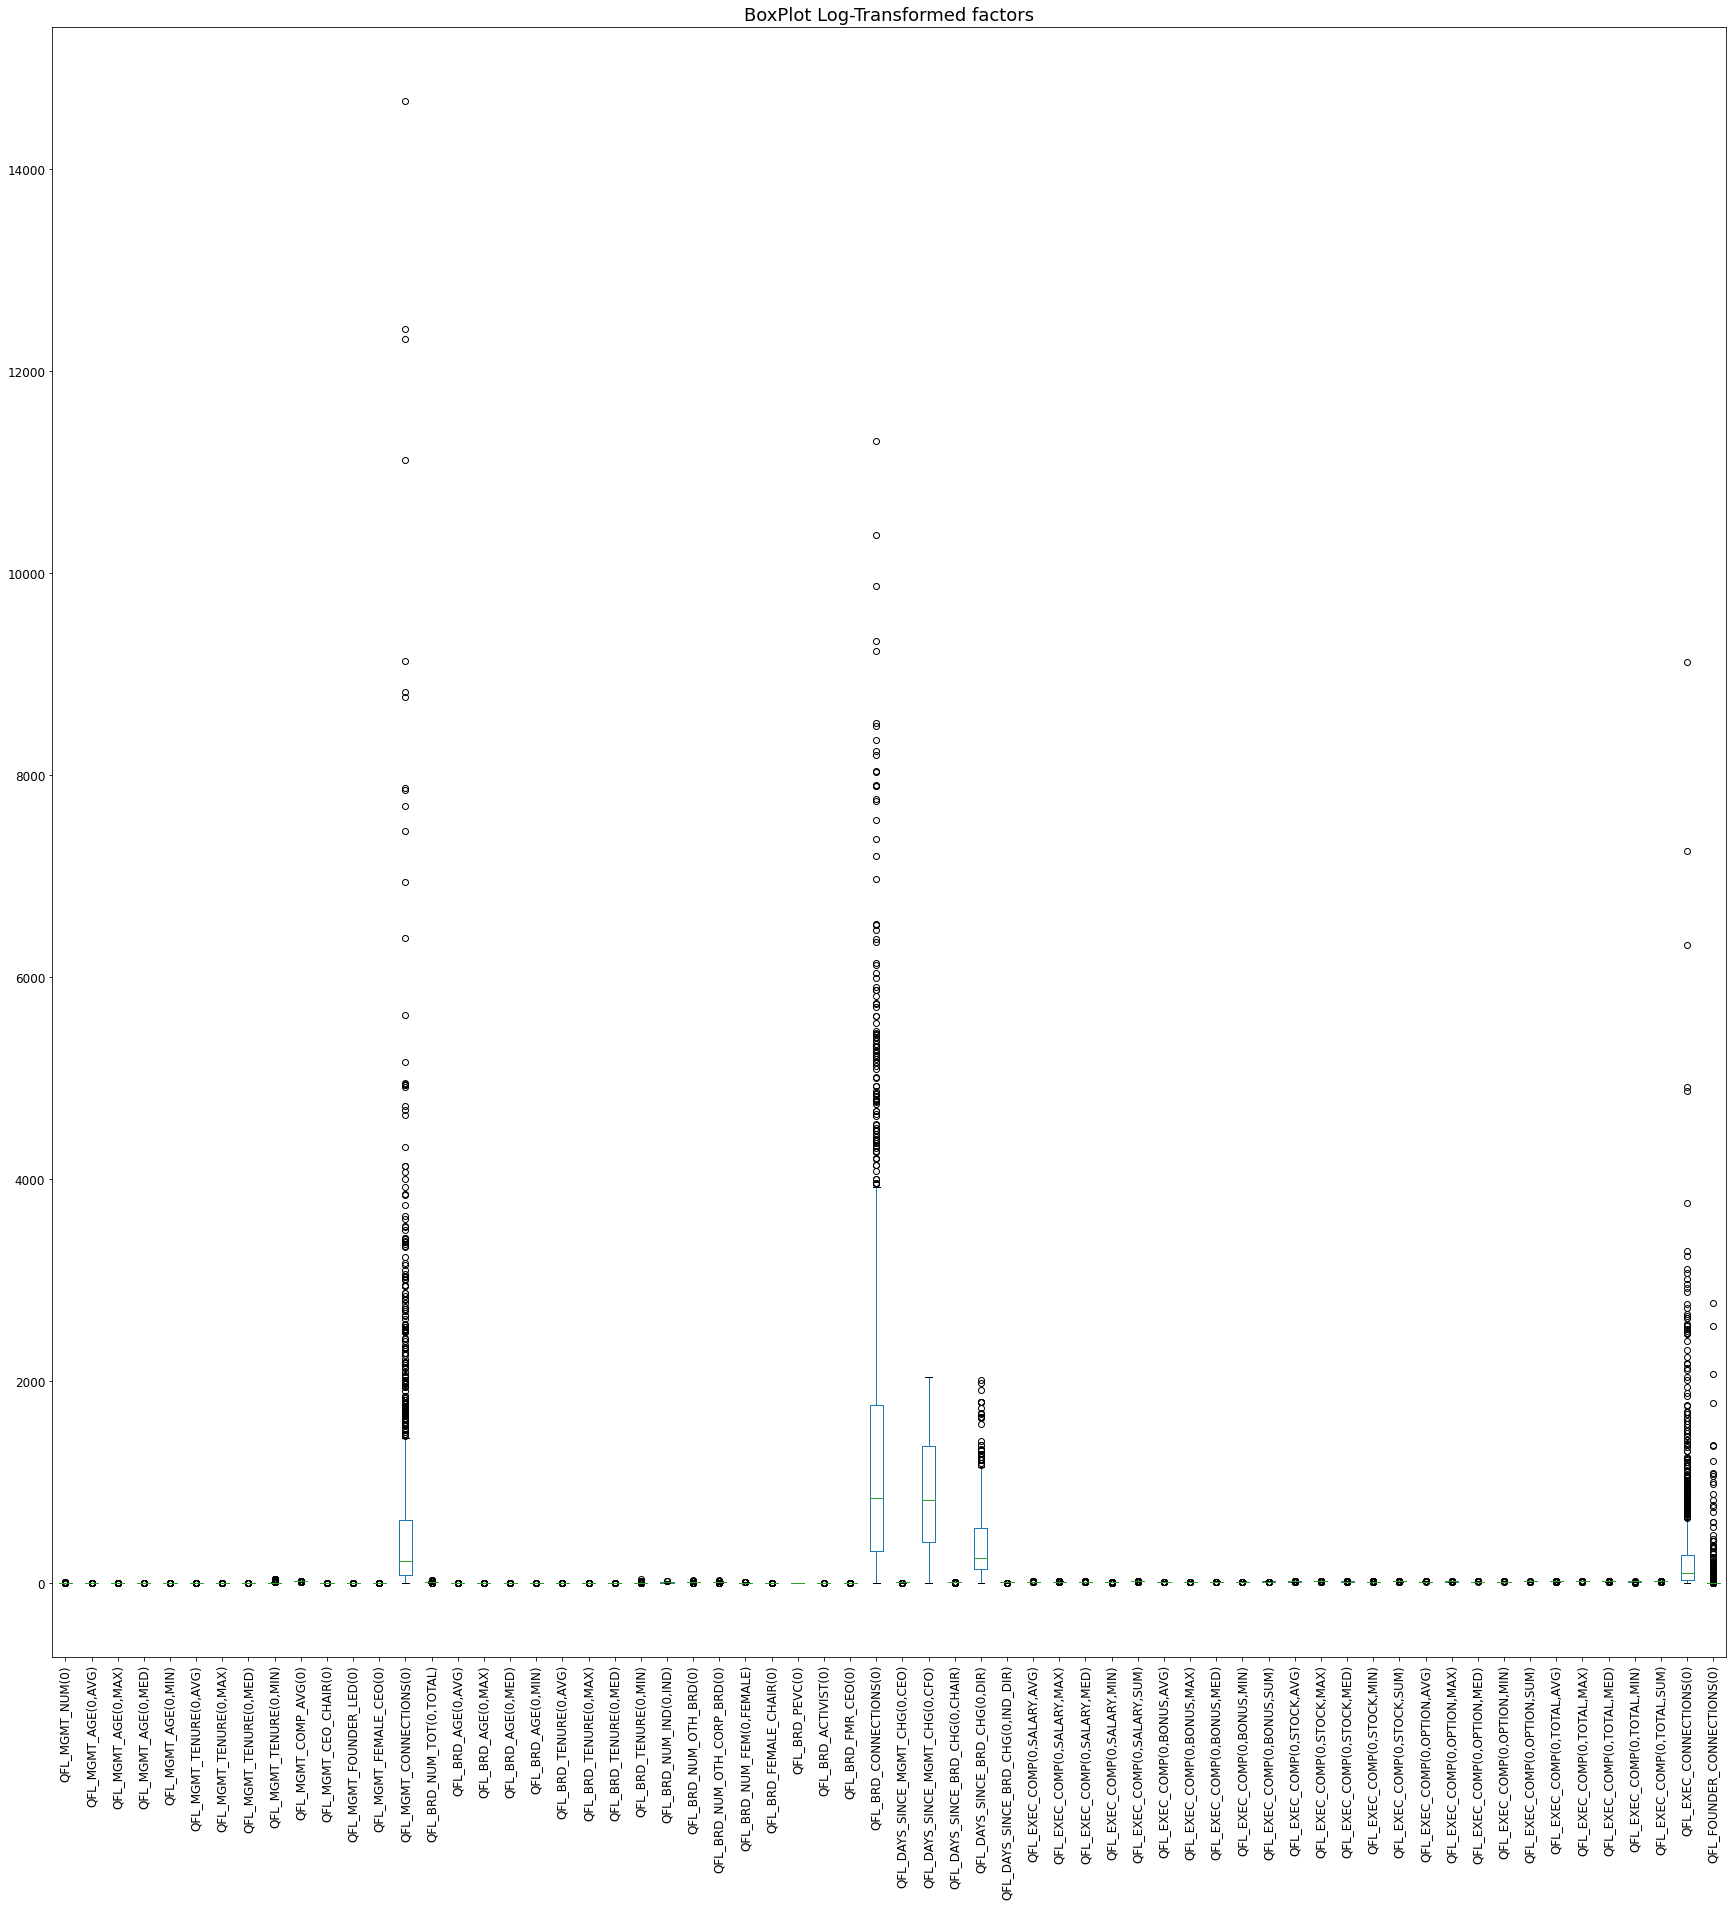

In [28]:
# Box-Whisker plot of Log-Transformed data

qfl_df_log.boxplot(grid=False, rot=90, fontsize=12, figsize = (30,30)).set_title('BoxPlot Log-Transformed factors', fontsize = 18);

In [29]:
# MFR Z-Score of Log-Transformed and Z-Scored data

# Z-Score of Log-Transformed data

qfl_df_log_z = pd.DataFrame()

for factor in qfl_df_log:
    z_score = ( qfl_df_log[factor] - qfl_df_log[factor].mean() ) / qfl_df_log[factor].std()
    qfl_df_log_z[factor] = z_score

qfl_df_log_z['MFR'] = qfl_df_log_z.mean(axis = 1)

qfl_df_log_z.head()

,QFL_MGMT_NUM(0),"QFL_MGMT_AGE(0,AVG)","QFL_MGMT_AGE(0,MAX)","QFL_MGMT_AGE(0,MED)","QFL_MGMT_AGE(0,MIN)","QFL_MGMT_TENURE(0,AVG)","QFL_MGMT_TENURE(0,MAX)","QFL_MGMT_TENURE(0,MED)","QFL_MGMT_TENURE(0,MIN)",QFL_MGMT_COMP_AVG(0),QFL_MGMT_CEO_CHAIR(0),QFL_MGMT_FOUNDER_LED(0),QFL_MGMT_FEMALE_CEO(0),QFL_MGMT_CONNECTIONS(0),"QFL_BRD_NUM_TOT(0,TOTAL)","QFL_BRD_AGE(0,AVG)","QFL_BRD_AGE(0,MAX)","QFL_BRD_AGE(0,MED)","QFL_BRD_AGE(0,MIN)","QFL_BRD_TENURE(0,AVG)","QFL_BRD_TENURE(0,MAX)","QFL_BRD_TENURE(0,MED)","QFL_BRD_TENURE(0,MIN)","QFL_BRD_NUM_IND(0,IND)",QFL_BRD_NUM_OTH_BRD(0),QFL_BRD_NUM_OTH_CORP_BRD(0),"QFL_BRD_NUM_FEM(0,FEMALE)",QFL_BRD_FEMALE_CHAIR(0),QFL_BRD_PEVC(0),QFL_BRD_ACTIVIST(0),QFL_BRD_FMR_CEO(0),QFL_BRD_CONNECTIONS(0),"QFL_DAYS_SINCE_MGMT_CHG(0,CEO)","QFL_DAYS_SINCE_MGMT_CHG(0,CFO)","QFL_DAYS_SINCE_BRD_CHG(0,CHAIR)","QFL_DAYS_SINCE_BRD_CHG(0,DIR)","QFL_DAYS_SINCE_BRD_CHG(0,IND_DIR)","QFL_EXEC_COMP(0,SALARY,AVG)","QFL_EXEC_COMP(0,SALARY,MAX)","QFL_EXEC_COMP(0,SALARY,MED)","QFL_EXEC_COMP(0,SALARY,MIN)","QFL_EXEC_COMP(0,SALARY,SUM)","QFL_EXEC_COMP(0,BONUS,AVG)","QFL_EXEC_COMP(0,BONUS,MAX)","QFL_EXEC_COMP(0,BONUS,MED)","QFL_EXEC_COMP(0,BONUS,MIN)","QFL_EXEC_COMP(0,BONUS,SUM)","QFL_EXEC_COMP(0,STOCK,AVG)","QFL_EXEC_COMP(0,STOCK,MAX)","QFL_EXEC_COMP(0,STOCK,MED)","QFL_EXEC_COMP(0,STOCK,MIN)","QFL_EXEC_COMP(0,STOCK,SUM)","QFL_EXEC_COMP(0,OPTION,AVG)","QFL_EXEC_COMP(0,OPTION,MAX)","QFL_EXEC_COMP(0,OPTION,MED)","QFL_EXEC_COMP(0,OPTION,MIN)","QFL_EXEC_COMP(0,OPTION,SUM)","QFL_EXEC_COMP(0,TOTAL,AVG)","QFL_EXEC_COMP(0,TOTAL,MAX)","QFL_EXEC_COMP(0,TOTAL,MED)","QFL_EXEC_COMP(0,TOTAL,MIN)","QFL_EXEC_COMP(0,TOTAL,SUM)",QFL_EXEC_CONNECTIONS(0),QFL_FOUNDER_CONNECTIONS(0),MFR
0,1.787711,-0.486880,-0.568013,-0.039827,-1.125717,0.456415,0.670695,0.379611,-0.367552,2.065062,-0.543912,-0.371605,-0.227981,0.944426,-1.285736,1.053017,-0.279060,1.775735,1.175432,0.697169,0.151203,0.791693,2.127221,-0.120942,-0.590926,-0.498946,-0.496331,-0.252735,1.173505,-0.149596,-0.481590,0.362062,NaN,1.882771,NaN,NaN,NaN,1.592913,2.225275,1.338067,0.396525,1.787725,NaN,NaN,NaN,NaN,NaN,2.288362,1.384084,2.586650,2.622607,2.221420,NaN,NaN,NaN,NaN,NaN,2.160326,1.032942,2.604445,1.195241,2.160326,-0.186356,-0.146636,0.737406
1,3.029082,-0.464548,-0.232406,-0.460821,-0.946271,0.005654,0.772657,-0.267928,-0.546661,2.235904,-0.543912,-0.371605,-0.227981,1.104368,0.322190,-0.613330,-0.279060,-0.546316,0.234518,-0.385847,0.479340,-0.436759,-0.269078,1.413430,0.932689,1.053330,1.199909,-0.252735,1.173505,-0.149596,-0.481590,1.570231,NaN,NaN,NaN,NaN,NaN,1.409683,1.828301,0.924128,0.462367,1.188601,NaN,NaN,NaN,NaN,NaN,1.929534,1.780459,1.990427,1.785903,1.875898,NaN,NaN,NaN,NaN,NaN,2.111944,1.894113,2.073641,1.060957,2.111944,0.393345,-0.146636,0.667857
2,1.521227,-0.375638,-1.093382,-0.248375,0.352073,0.583446,0.267762,0.770880,-0.258173,1.143869,1.837381,2.689346,-0.227981,-0.425619,0.000604,0.580476,0.401454,0.344665,0.918717,0.165244,0.356004,-0.113019,-0.708869,1.106555,-0.590926,-0.498946,1.199909,-0.252735,1.173505,-0.149596,-0.481590,0.927162,NaN,1.991294,NaN,-0.834923,-1.482757,-3.814611,-3.961784,-3.445579,-0.670380,-3.605318,NaN,NaN,NaN,NaN,NaN,3.469130,2.490607,3.635582,3.843149,1.577884,NaN,NaN,NaN,NaN,NaN,1.196899,2.299890,-3.727261,-1.848284,1.196899,-0.458037,-0.088514,0.166910
3,2.373497,-1.880046,-1.274780,-1.587042,-2.519810,-0.541326,-0.414095,-0.323000,-0.493339,2.160766,1.837381,2.689346,-0.227981,1.224763,-0.642566,-2.510265,-0.105403,-2.794432,-2.519643,-0.343628,-0.262348,-1.995982,-0.449505,0.185932,0.018520,0.121964,0.634496,-0.252735,1.173505,-0.149596,-0.481590,0.226118,NaN,1.610574,NaN,NaN,NaN,-0.479008,-0.456550,0.675038,-6.582321,-0.544501,0.663373,0.804559,0.606682,0.569471,0.997717,2.185505,1.277040,2.485176,2.613068,1.875514,NaN,NaN,NaN,NaN,NaN,2.245957,1.144616,2.477247,1.555648,2.245957,0.253179,-0.133720,0.163044
4,-1.082703,0.621941,0.861243,1.321778,0.048087,-0.917969,-1.067769,-0.854058,-0.155630,5.121990,-0.543912,2.689346,-0.22798

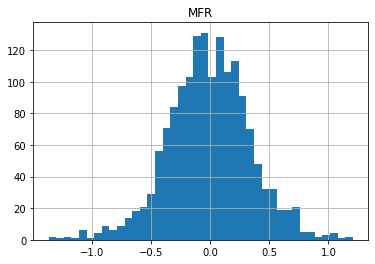

In [30]:
# MFR Distribution (of Log-Transformed and Z-Score factors)

pd.DataFrame(qfl_df_log_z['MFR']).hist(bins = int(np.sqrt(len(qfl_df_log_z['MFR']))));

In [31]:
# Check Infomation Coefficient: MRF (Components: All, Z-Scored & Log-Transformed)

sp_corr_z_log, sp_pval_z_log = stats.spearmanr(-qfl_df_log_z['MFR'].replace(np.nan, 0), qfl_df['p_total_return'].replace(np.nan, 0))
print('Information Coefficient: {0}'.format(round(sp_corr_z_log,2)))
print('Information Coefficient (P-Value): {0}'.format(round(sp_pval_z_log,2)))

Information Coefficient: -0.0
Information Coefficient (P-Value): 0.85


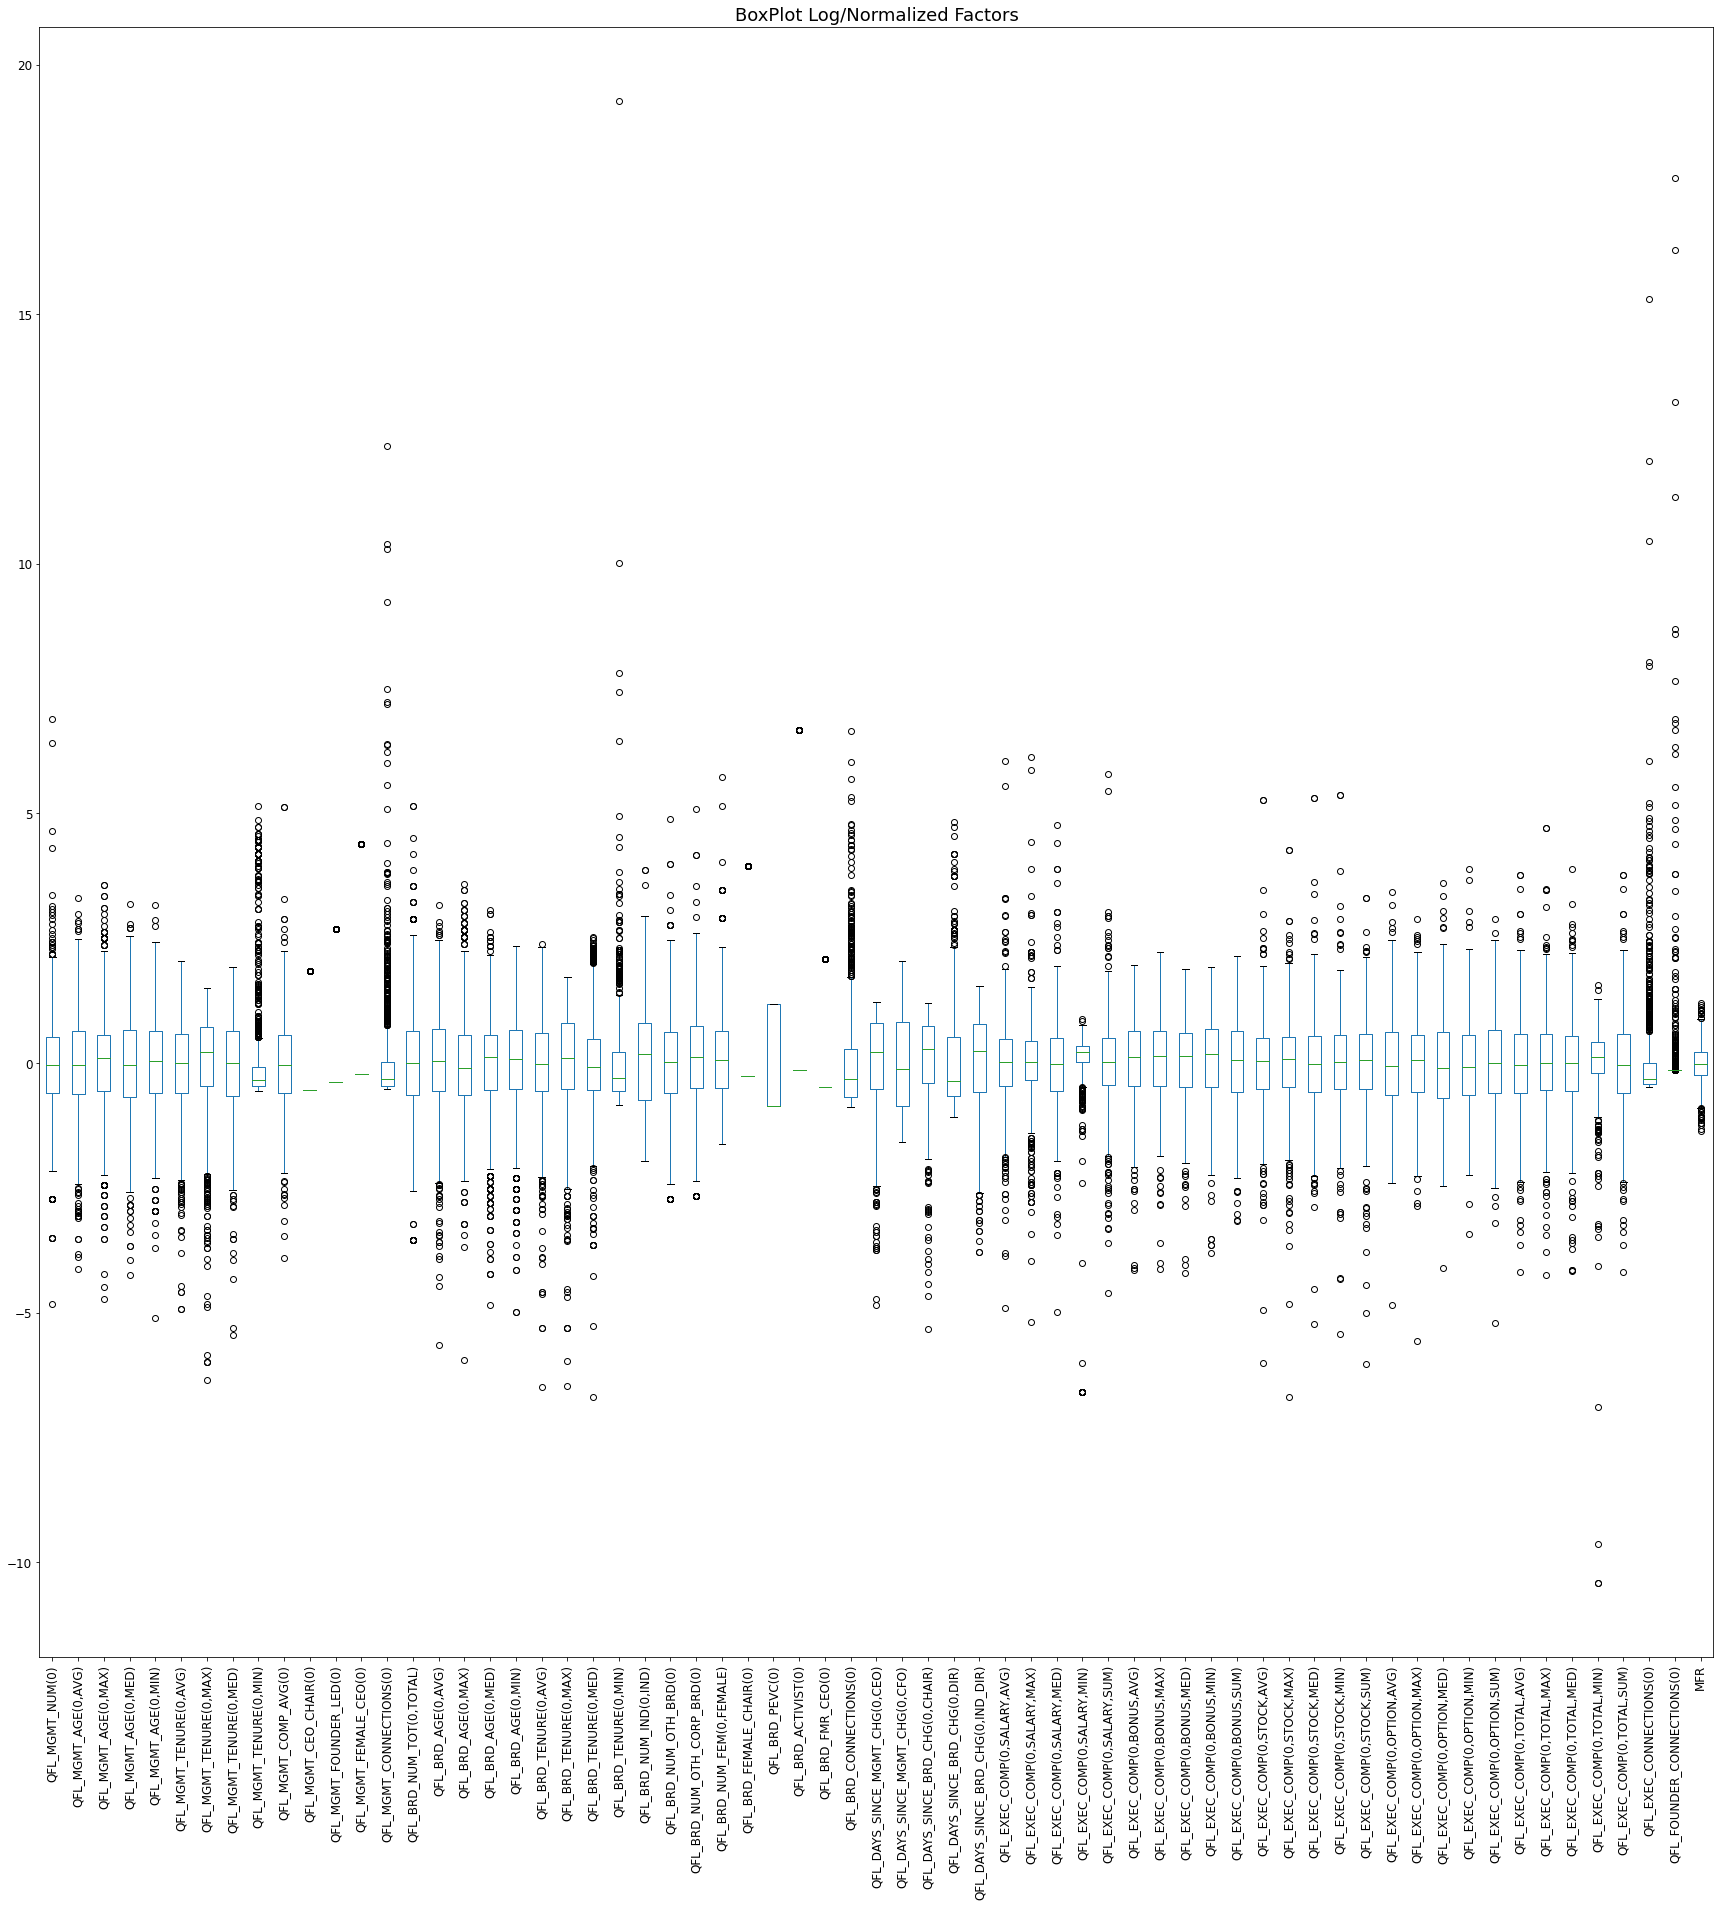

In [32]:
# Box-Whisker plot of Log-Transformed and Z-Score data

qfl_df_log_z.boxplot(grid=False, rot=90, fontsize=12, figsize = (30,30)).set_title('BoxPlot Log/Normalized Factors', fontsize = 18);

In [33]:
# Check Universe Exposures (Geography, Size, Sector)

qfl_df['ison_screen'] = 1

qfl_df.head()

,BENCHMARK_ID,DATE,SECURITY_ID,Weight,proper_name,fg_gics_sector,proper,p_total_return,qfl_size_class,qfl_mkt_val_sec,QFL_MGMT_NUM(0),"QFL_MGMT_AGE(0,AVG)","QFL_MGMT_AGE(0,MAX)","QFL_MGMT_AGE(0,MED)","QFL_MGMT_AGE(0,MIN)","QFL_MGMT_TENURE(0,AVG)","QFL_MGMT_TENURE(0,MAX)","QFL_MGMT_TENURE(0,MED)","QFL_MGMT_TENURE(0,MIN)",QFL_MGMT_COMP_AVG(0),QFL_MGMT_CEO_CHAIR(0),QFL_MGMT_FOUNDER_LED(0),QFL_MGMT_FEMALE_CEO(0),QFL_MGMT_CONNECTIONS(0),"QFL_BRD_NUM_TOT(0,TOTAL)","QFL_BRD_AGE(0,AVG)","QFL_BRD_AGE(0,MAX)","QFL_BRD_AGE(0,MED)","QFL_BRD_AGE(0,MIN)","QFL_BRD_TENURE(0,AVG)","QFL_BRD_TENURE(0,MAX)","QFL_BRD_TENURE(0,MED)","QFL_BRD_TENURE(0,MIN)","QFL_BRD_NUM_IND(0,IND)",QFL_BRD_NUM_OTH_BRD(0),QFL_BRD_NUM_OTH_CORP_BRD(0),"QFL_BRD_NUM_FEM(0,FEMALE)",QFL_BRD_FEMALE_CHAIR(0),QFL_BRD_PEVC(0),QFL_BRD_ACTIVIST(0),QFL_BRD_FMR_CEO(0),QFL_BRD_CONNECTIONS(0),"QFL_DAYS_SINCE_MGMT_CHG(0,CEO)","QFL_DAYS_SINCE_MGMT_CHG(0,CFO)","QFL_DAYS_SINCE_BRD_CHG(0,CHAIR)","QFL_DAYS_SINCE_BRD_CHG(0,DIR)","QFL_DAYS_SINCE_BRD_CHG(0,IND_DIR)","QFL_EXEC_COMP(0,SALARY,AVG)","QFL_EXEC_COMP(0,SALARY,MAX)","QFL_EXEC_COMP(0,SALARY,MED)","QFL_EXEC_COMP(0,SALARY,MIN)","QFL_EXEC_COMP(0,SALARY,SUM)","QFL_EXEC_COMP(0,BONUS,AVG)","QFL_EXEC_COMP(0,BONUS,MAX)","QFL_EXEC_COMP(0,BONUS,MED)","QFL_EXEC_COMP(0,BONUS,MIN)","QFL_EXEC_COMP(0,BONUS,SUM)","QFL_EXEC_COMP(0,STOCK,AVG)","QFL_EXEC_COMP(0,STOCK,MAX)","QFL_EXEC_COMP(0,STOCK,MED)","QFL_EXEC_COMP(0,STOCK,MIN)","QFL_EXEC_COMP(0,STOCK,SUM)","QFL_EXEC_COMP(0,OPTION,AVG)","QFL_EXEC_COMP(0,OPTION,MAX)","QFL_EXEC_COMP(0,OPTION,MED)","QFL_EXEC_COMP(0,OPTION,MIN)","QFL_EXEC_COMP(0,OPTION,SUM)","QFL_EXEC_COMP(0,TOTAL,AVG)","QFL_EXEC_COMP(0,TOTAL,MAX)","QFL_EXEC_COMP(0,TOTAL,MED)","QFL_EXEC_COMP(0,TOTAL,MIN)","QFL_EXEC_COMP(0,TOTAL,SUM)",QFL_EXEC_CONNECTIONS(0),QFL_FOUNDER_CONNECTIONS(0),ison_screen
0,890100,30-Nov-2020,03783310,4.204100,Apple Inc.,Information Technology,United States,11.457372,Mega Cap,2024064.4,31.0,53.00,59.0,55.0,41.0,14.73,34.50,12.41,1.36,21272920.0,0.0,0.0,0.0,1672.0,7.0,66.00,71.0,70.0,58.0,13.74,22.75,12.91,5.25,6.0,7.0,7.0,2.0,0.0,1.0,0.0,0.0,1876.0,NaN,1948.0,NaN,NaN,NaN,1251310.1,3000000.0,1000000.0,630361.0,7507861.0,NaN,NaN,NaN,NaN,NaN,20600638.0,21633416.0,21633416.0,16469527.0,103003190.0,NaN,NaN,NaN,NaN,NaN,21440474.0,25231800.0,23743080.0,11555466.0,21440474.0,166.0,0.0,1
1,890100,30-Nov-2020,59491810,3.141281,Microsoft Corporation,Information Technology,United States,3.900588,Mega Cap,1618475.4,59.0,53.10,61.0,53.0,42.0,10.72,36.91,7.08,0.05,23641260.0,0.0,0.0,0.0,1854.0,12.0,58.92,71.0,59.0,51.0,6.72,28.91,5.00,1.00,11.0,12.0,12.0,5.0,0.0,1.0,0.0,0.0,3689.0,NaN,NaN,NaN,NaN,NaN,1165400.0,2500000.0,860000.0,715000.0,5827000.0,NaN,NaN,NaN,NaN,NaN,15074426.0,30718608.0,12402137.0,6983520.0,75372130.0,NaN,NaN,NaN,NaN,NaN,20828104.0,44321788.0,16667713.0,9575482.0,20828104.0,501.0,0.0,1
2,890100,30-Nov-2020,02313510,2.735749,"Amazon.com, Inc.",Consumer Discretionary,United States,2.805829,Mega Cap,1589567.8,27.0,53.50,56.0,54.0,50.0,16.11,26.42,17.42,2.16,12040263.0,1.0,1.0,0.0,113.0,11.0,63.91,75.0,63.0,56.0,9.67,26.42,6.42,0.22,10.0,7.0,7.0,5.0,0.0,1.0,0.0,0.0,2724.0,NaN,2009.0,NaN,82.0,82.0,153368.0,175000.0,175000.0,81840.0,766840.0,NaN,NaN,NaN,NaN,NaN,57573240.0,57573240.0,57573240.0,57573240.0,57573240.0,NaN,NaN,NaN,NaN,NaN,12040263.0,57796740.0,348809.0,163200.0,12040263.0,9.0,9.0,1
3,890100,30-Nov-2020,30303M10,1.356526,"Facebook, Inc. Class A",Communication Services,United States,-1.375598,Mega Cap,665827.3,42.0,47.12,55.0,48.0,34.0,7.29,16.82,6.75,0.44,22568776.0,1.0,1.0,0.0,1991.0,9.0,51.78,72.0,50.0,35.0,6.91,16.82,1.50,0.68,7.0,9.0,9.0,4.0,0.0,1.0,0.0,0.0,1672.0,NaN,1795.0,NaN,NaN,NaN,559846.6,875385.0,785385.0,1.0,2799233.0,1324960.3,2291288.0,1099312.5,809928.0,5299841.0,18836496.0,19678924.0,19678924.0,16309218.0,75345980.0,NaN,NaN,NaN,NaN,NaN,22568776.0,27144148.0,21812976.0,19136744.0,22568776.0,420.0,2.0,1
4,890100,30-Nov-2020,02079K10,1.085045,Alphabet Inc. Class C,Communication Services,Unit

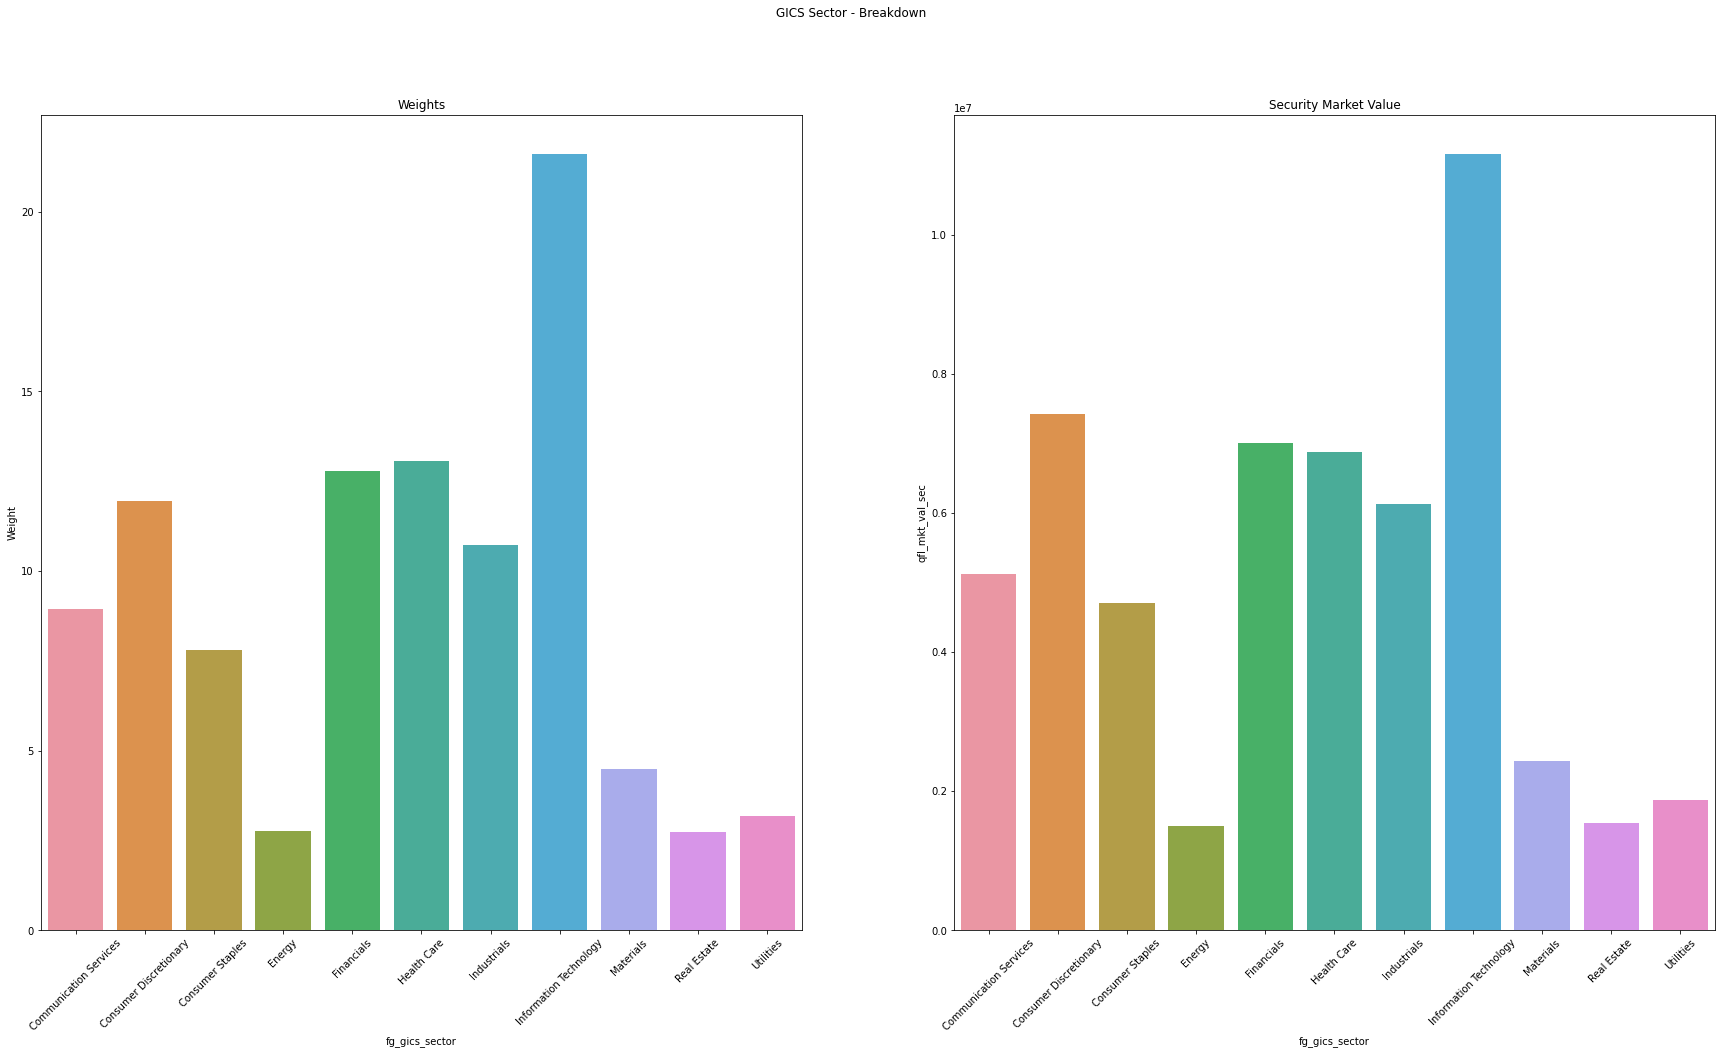

In [34]:
# Group universe

# GICS Sector
GICS_grouped = qfl_df.groupby('fg_gics_sector').sum()

fig, axes = plt.subplots(1, 2, figsize=(30, 15))
fig.suptitle('GICS Sector - Breakdown')
axes[0].set_title('Weights')
axes[1].set_title('Security Market Value')

chart = sns.barplot(ax=axes[0], x = GICS_grouped.index, y = 'Weight', data = GICS_grouped)
chart.set_xticklabels(chart.get_xticklabels(), rotation=45)
chart = sns.barplot(ax=axes[1], x = GICS_grouped.index, y = 'qfl_mkt_val_sec', data = GICS_grouped)
chart.set_xticklabels(chart.get_xticklabels(), rotation=45);

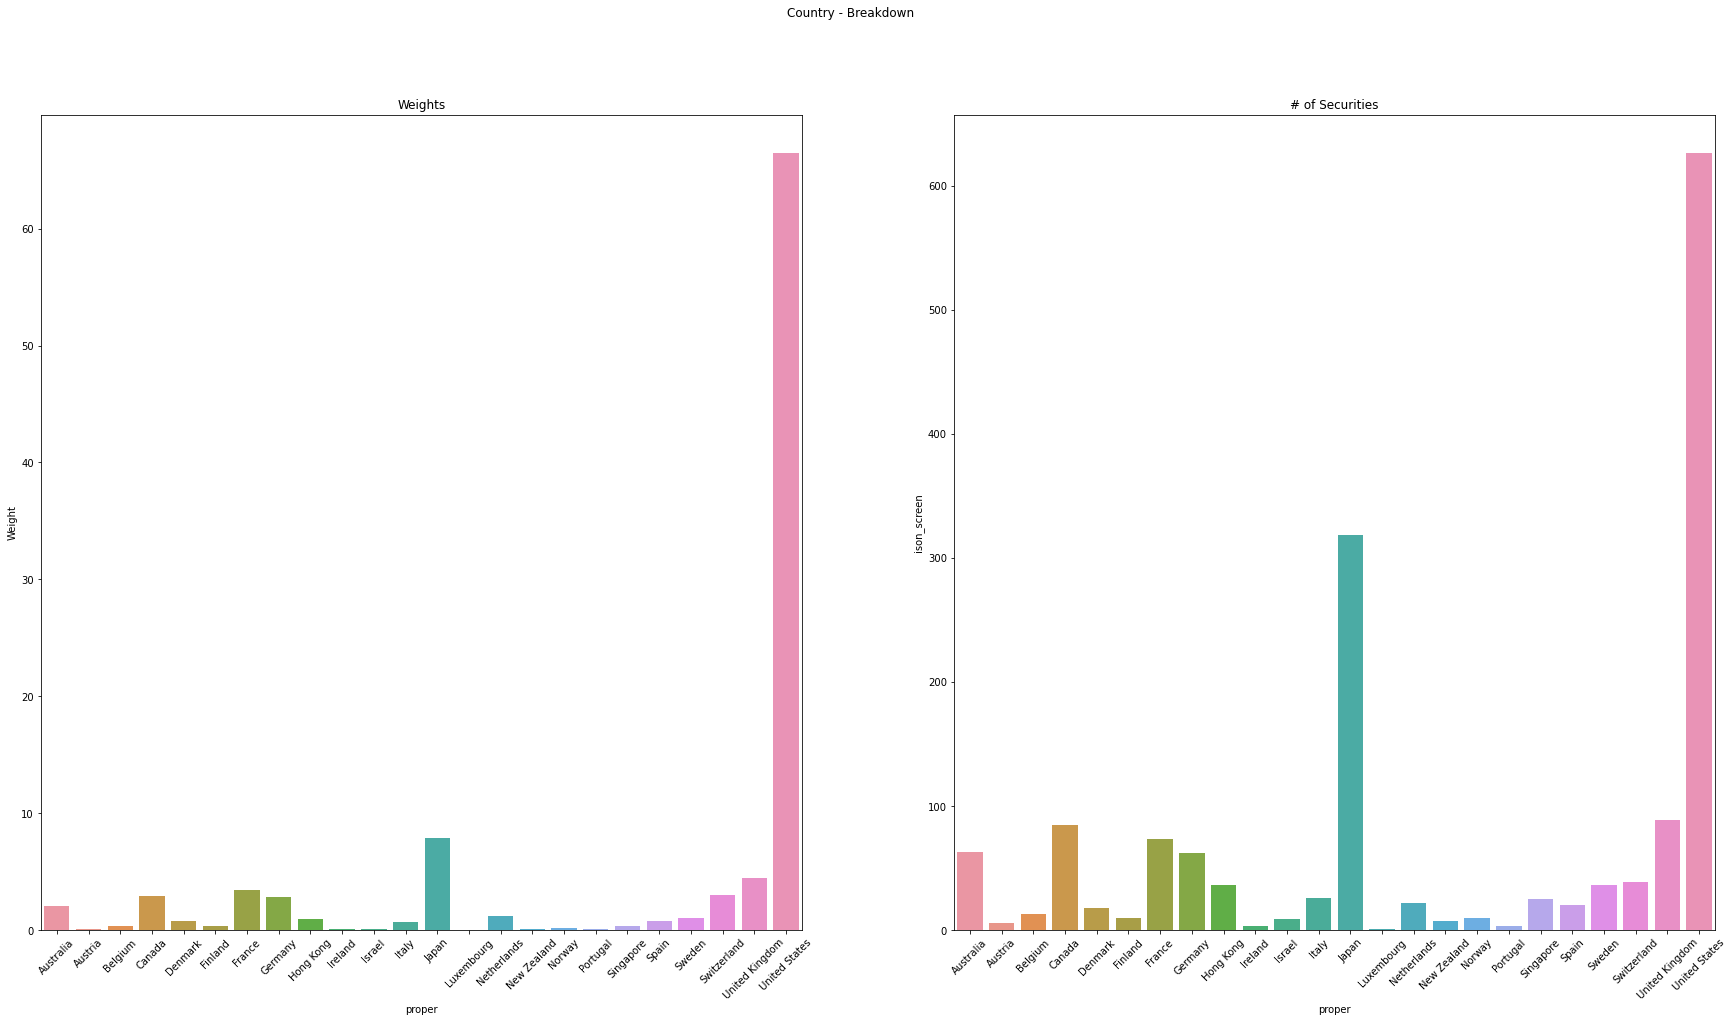

In [35]:
# Group universe

# Country
Country_grouped = qfl_df.groupby('proper').sum()

fig, axes = plt.subplots(1, 2, figsize=(30, 15))
fig.suptitle('Country - Breakdown')
axes[0].set_title('Weights')
axes[1].set_title('# of Securities')

chart = sns.barplot(ax=axes[0], x = Country_grouped.index, y = 'Weight', data = Country_grouped)
chart.set_xticklabels(chart.get_xticklabels(), rotation=45)
chart = sns.barplot(ax=axes[1], x = Country_grouped.index, y = 'ison_screen', data = Country_grouped)
chart.set_xticklabels(chart.get_xticklabels(), rotation=45);

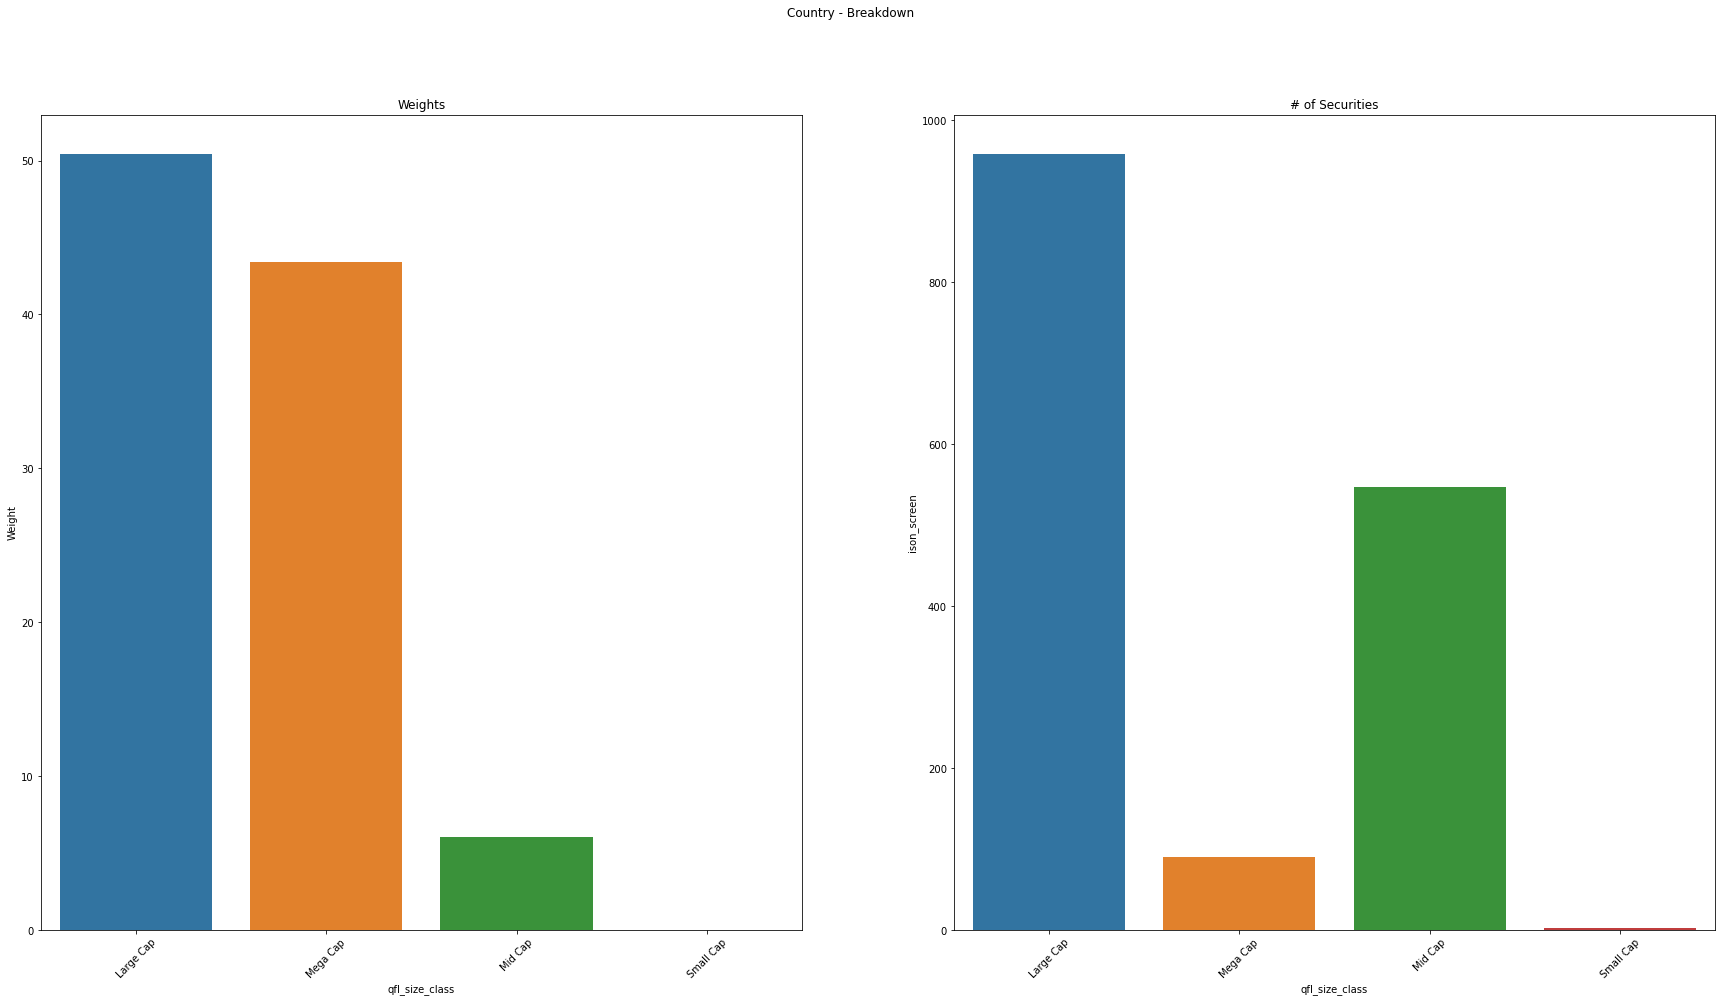

In [36]:
# Group universe

# Size
Size_grouped = qfl_df.groupby('qfl_size_class').sum()

fig, axes = plt.subplots(1, 2, figsize=(30, 15))
fig.suptitle('Country - Breakdown')
axes[0].set_title('Weights')
axes[1].set_title('# of Securities')

chart = sns.barplot(ax=axes[0], x = Size_grouped.index, y = 'Weight', data = Size_grouped)
chart.set_xticklabels(chart.get_xticklabels(), rotation=45)
chart = sns.barplot(ax=axes[1], x = Size_grouped.index, y = 'ison_screen', data = Size_grouped)
chart.set_xticklabels(chart.get_xticklabels(), rotation=45);

In [37]:
# Feature Selection

In [38]:
# Discard features with more than 80 NAs

qfl_filtered = qfl_df[qfl_df[qfl_df.columns[filter_idx]].isna().sum(axis = 0)[qfl_df[qfl_df.columns[filter_idx]].isna().sum(axis = 0) < 80].index]

In [39]:
# Replace NAs for retained features with feature's average

for col in qfl_filtered.columns:
    qfl_filtered[col] = qfl_filtered[col].replace(np.nan, qfl_filtered[col].mean(axis = 0))
    
qfl_df['p_total_return'] = qfl_df['p_total_return'].replace(np.nan, 0);

<ipython-input-39-d861f91d7765>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  qfl_filtered[col] = qfl_filtered[col].replace(np.nan, qfl_filtered[col].mean(axis = 0))


In [40]:
from sklearn.feature_selection import RFE
from sklearn.feature_selection import RFECV
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso

X = qfl_filtered
Y = qfl_df['p_total_return']

#RECURSIVE FEATURE ELIMINATION

lin_reg = Lasso()
rfe = RFE(lin_reg, n_features_to_select=3, step = 1)
fit_rfe = rfe.fit(X, Y)
print("Num Features: %s" % (fit_rfe.n_features_))
print("Selected Features: %s" % (fit_rfe.support_))
print("Feature Ranking: %s" % (fit_rfe.ranking_))


Num Features: 3
Selected Features: [False False False False  True False False False  True False False False
 False False False False False False False  True False False False False
 False False False False False False False False False]
Feature Ranking: [ 4 18 17 16  1 15  3 14  1 22 24 25  7 29 26 30 31  2 23  1 13 12 11 10
 19 20  9 27 28 21  8  6  5]


In [41]:
qfl_filtered.columns[fit_rfe.support_]

Index(['QFL_MGMT_AGE(0,MIN)', 'QFL_MGMT_TENURE(0,MIN)',
       'QFL_BRD_TENURE(0,MAX)'],
      dtype='object')

In [42]:
qfl_filtered[qfl_filtered.columns[fit_rfe.support_]].corr()

,"QFL_MGMT_AGE(0,MIN)","QFL_MGMT_TENURE(0,MIN)","QFL_BRD_TENURE(0,MAX)"
"QFL_MGMT_AGE(0,MIN)",1.000000,0.389436,0.268091
"QFL_MGMT_TENURE(0,MIN)",0.389436,1.000000,0.410438
"QFL_BRD_TENURE(0,MAX)",0.268091,0.410438,1.000000


In [43]:
qfl_filtered[qfl_filtered.columns[fit_rfe.support_]]

,"QFL_MGMT_AGE(0,MIN)","QFL_MGMT_TENURE(0,MIN)","QFL_BRD_TENURE(0,MAX)"
0,41.0,1.36,22.750000
1,42.0,0.05,28.910000
2,50.0,2.16,26.420000
3,34.0,0.44,16.820000
4,48.0,2.91,21.580000
...,...,...,...
1595,56.0,1.33,31.910000
1596,53.0,3.50,19.000000
1597,45.0,1.12,25.104568
1598,51.0,3.67,36.670000


In [44]:
# MFR Z-Score after Feature Selection

qfl_mfr_RFE = pd.DataFrame()

for factor in qfl_filtered[qfl_filtered.columns[fit_rfe.support_]]:
    z_score_RFE = ( qfl_filtered[factor] - qfl_filtered[factor].mean() ) / qfl_filtered[factor].std()
    qfl_mfr_RFE[factor] = z_score_RFE

qfl_mfr_RFE['MFR'] = qfl_mfr_RFE.mean(axis = 1)

qfl_mfr_RFE.head()

,"QFL_MGMT_AGE(0,MIN)","QFL_MGMT_TENURE(0,MIN)","QFL_BRD_TENURE(0,MAX)",MFR
0,-1.120025,-0.368128,-0.164314,-0.550822
1,-0.962685,-0.547518,0.265563,-0.414880
2,0.296034,-0.258578,0.091798,0.043085
3,-2.221404,-0.494112,-0.578140,-1.097885
4,-0.018645,-0.155874,-0.245963,-0.140161


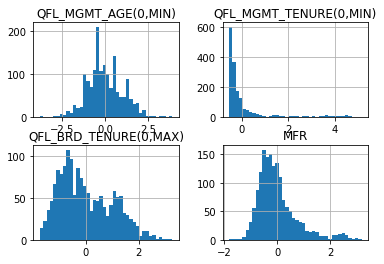

In [45]:
qfl_mfr_RFE.hist(bins = int(np.sqrt(len(qfl_mfr_RFE['MFR']))));

In [46]:
# Check Infomation Coefficient: MFR (Components: RFE's Feature Selected, Z-Scored)

sp_corr_z_rfe, sp_pval_z_rfe = stats.spearmanr(-qfl_mfr_RFE['MFR'].replace(np.nan, 0), qfl_df['p_total_return'].replace(np.nan, 0))
print('Information Coefficient: {0}'.format(round(sp_corr_z_rfe,2)))
print('Information Coefficient (P-Value): {0}'.format(round(sp_pval_z_rfe,2)))

Information Coefficient: 0.09
Information Coefficient (P-Value): 0.0


# Information Coefficient Summary (LVRB)

### Feature Selection: Recoursive Feature Elimination (RFE + Lasso) (3 Top Components)

In [47]:
print('Information Coefficient: {0}'.format(round(sp_corr_z_rfe,2)))
print('Information Coefficient (P-Value): {0}'.format(round(sp_pval_z_rfe,2)))

Information Coefficient: 0.09
Information Coefficient (P-Value): 0.0


### Z-Score + Log-Transformation (All Components)

In [48]:
print('Information Coefficient: {0}'.format(round(sp_corr_z_log,2)))
print('Information Coefficient (P-Value): {0}'.format(round(sp_pval_z_log,2)))

Information Coefficient: -0.0
Information Coefficient (P-Value): 0.85


### Z-Score Only (All Components)

In [49]:
print('Information Coefficient: {0}'.format(round(sp_corr_z,2)))
print('Information Coefficient (P-Value): {0}'.format(round(sp_pval_z,2)))

Information Coefficient: 0.05
Information Coefficient (P-Value): 0.03
